In [1]:
# This is the import cell
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as ticker
from collections import OrderedDict
from scipy import stats
from PIL import Image
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
first = True
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 10)

# Here are my rc parameters for matplotlib
fsize = 10
mpl.rc('font', serif='Helvetica Neue') 
mpl.rcParams.update({'font.size': fsize})
mpl.rcParams['figure.figsize'] = 3.2, 2.8
mpl.rcParams['figure.dpi'] = 2000
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['axes.linewidth'] = 1.5
# Set x tick params
mpl.rcParams['xtick.major.size'] = 4.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.minor.width'] = 1.25
# Set y tick params
mpl.rcParams['ytick.major.size'] = 4.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.minor.width'] = 1.25
# Load LaTeX and amsmath
# mpl.rc('text', usetex=True)
# mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [2]:
# Get your text data to overlay
if first:
    parent = os.getcwd()
os.chdir(parent)

# Grab file names from data folder
comp = os.listdir('../all_txt')
try:
    comp.remove('.DS_Store')
except:
    print(".DS_Store not in directory")

.DS_Store not in directory


In [3]:
# Some functions to get the relevant data from the filenames
def checkFile(fname, string):
    for i in xrange(len(fname)):
        if fname[i] == string[0]:
#             print"{} matches {}".format(fname[i], string[0])
            for j in xrange(1, len(string)):
                if (i + j) > (len(fname) - 1):
                    break
                elif fname[i + j] == string[j]:
#                     print"{} matches {}".format(fname[i+j], string[j])
                    if j == (len(string) - 1):
#                         print"Final match!"
                        return True
                else:
                    break
    return False
    
def txtValue(fname, string):
    out = ""
    index = 0
    for i in xrange(len(fname)):
        if fname[i] == string[0]:
            for j in xrange(1, len(string)):
                if (i + j) > (len(fname) - 1):
                    break
                elif fname[i + j] == string[j]:
                    if j == (len(string) - 1):
                        # Last index of search string
                        index = i + j
                else:
                    break
                        
    # First index of value
    index += 1
    mybool = True
    while mybool:
        if fname[index].isdigit():
            out = out + fname[index]
            index += 1
        elif fname[index] == ".":    
            if fname[index+1].isdigit():
                out = out + fname[index]
                index += 1
            else:
                mybool = False
        else:
            mybool = False
    return float(out)

# Sorting functions
def multiSort(arr1, arr2, arr3, arr4):
    """Sort an array the slow (but certain) way, returns original indices in sorted order"""
    # Doing this for PeR, PeS, xS in this case
    cpy1 = np.copy(arr1)
    cpy2 = np.copy(arr2)
    cpy3 = np.copy(arr3)
    cpy4 = np.copy(arr4)
    ind = np.arange(0, len(arr1))
    for i in xrange(len(cpy1)):
        for j in xrange(len(cpy1)):
            # Sort by first variable
            if cpy1[i] > cpy1[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                cpy4[i], cpy4[j] = cpy4[j], cpy4[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            # If first variable is equal, resort to second variable
            elif cpy1[i] == cpy1[j] and cpy2[i] > cpy2[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                cpy4[i], cpy4[j] = cpy4[j], cpy4[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            elif cpy1[i] == cpy1[j] and cpy2[i] == cpy2[j] and cpy3[i] > cpy3[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                cpy4[i], cpy4[j] = cpy4[j], cpy4[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
            elif cpy1[i] == cpy1[j] and cpy2[i] == cpy2[j] and cpy3[i] == cpy3[j] and cpy4[i] > cpy4[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                cpy4[i], cpy4[j] = cpy4[j], cpy4[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
    return ind

def indSort(arr1, arr2):
    """Take sorted index array, use to sort array"""
    # arr1 is array to sort
    # arr2 is index array
    cpy = np.copy(arr1)
    for i in xrange(len(arr1)):
        arr1[i] = cpy[arr2[i]]

In [4]:
# Grab parameters, sort them
chkStrings = ["pe", "pa", "pb", "xa", "eps", "phi", "cluster", "dtau"]
default = [0., 0., 0., 50, 1., 60., 0, 0.000001]
storeVals = [[] for i in chkStrings]
for i in comp:
    for j in range(0, len(chkStrings)):
        if chkStrings[j] != "cluster":
            if checkFile(i, chkStrings[j]):
                storeVals[j].append(txtValue(i, chkStrings[j]))
            else:
                storeVals[j].append(default[j])  
        else:
            if checkFile(i, chkStrings[j]):
                storeVals[j].append(1)
            else:
                storeVals[j].append(default[j]) 
                
# Issue with epsilon in file output 0 -> 0.0001
for i in range(0, len(storeVals[4])):
    if storeVals[4][i] == 0.0:
        storeVals[4][i] = 0.0001

# Sort the arrays
if len(storeVals[0]) > 1:
    # Sort them!
#     print("Sorting... ")
    # Sort by: pe, phi, epsilon, cluster
    indArr = multiSort(storeVals[chkStrings.index("pa")],
                       storeVals[chkStrings.index("pb")],
                       storeVals[chkStrings.index("eps")],
                       storeVals[chkStrings.index("cluster")])
    indSort(comp, indArr)
    for i in storeVals:
        indSort(i, indArr)
    
# Now that the data is sorted, read it into a dataframe
all_comp = []
os.chdir(parent)
os.chdir('../all_txt')
for i in comp:
    print(i)
    df = pd.read_csv(i, sep='\s+', skiprows=[0], names=['tauB', 'NinLC', 'phiG', 'phiL'])
    display(df)
    all_comp.append(df)
os.chdir(parent)

# This is how you access the data at different levels
display(all_comp[0])

cdata_cluster_pa0_pb0_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,2693,0.59853,0.60345


cdata_pa0_pb0_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,5482,0.59591,0.60685
2,0.2,3782,0.59562,0.60617
3,0.3,2617,0.59669,0.61055
4,0.4,2834,0.59672,0.60701
...,...,...,...,...
348,34.8,2040,0.59908,0.60342
349,34.9,2072,0.59934,0.60119
350,35.0,2525,0.59937,0.60337
351,35.1,1413,0.59923,0.60494


cdata_pa0_pb50_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,94316,0.59671,0.60136
2,0.2,93498,0.59137,0.60263
3,0.3,92689,0.58767,0.60409
4,0.4,92457,0.58345,0.60536
...,...,...,...,...
995,99.5,91118,0.56310,0.61220
996,99.6,90601,0.56192,0.61291
997,99.7,90621,0.56300,0.61270
998,99.8,90910,0.56244,0.61245


cdata_pa0_pb100_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,94143,0.59227,0.60250
2,0.2,92589,0.58120,0.60627
3,0.3,92137,0.57381,0.60901
4,0.4,91902,0.56941,0.61075
...,...,...,...,...
995,99.5,90540,0.55347,0.61768
996,99.6,89610,0.55288,0.61871
997,99.7,89188,0.55507,0.61882
998,99.8,90592,0.55712,0.61705


cdata_pa0_pb150_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,92361,0.58727,0.60474
2,0.2,91360,0.57335,0.60978
3,0.3,91304,0.56591,0.61276
4,0.4,89441,0.56609,0.61472
...,...,...,...,...
995,99.5,89576,0.54942,0.62073
996,99.6,88909,0.55097,0.62102
997,99.7,89770,0.55382,0.61949
998,99.8,90216,0.55112,0.61936


cdata_pa0_pb200_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,90540,0.58077,0.60743
2,0.2,90770,0.56661,0.61291
3,0.3,90204,0.56457,0.61374
4,0.4,89367,0.56376,0.61565
...,...,...,...,...
995,99.5,89589,0.56094,0.61630
996,99.6,89630,0.56518,0.61545
997,99.7,89812,0.56344,0.61517
998,99.8,89230,0.56193,0.61706


cdata_pa0_pb250_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,90573,0.57505,0.60947
2,0.2,89180,0.56530,0.61486
3,0.3,89265,0.56776,0.61435
4,0.4,88929,0.56677,0.61454
...,...,...,...,...
995,99.5,88420,0.56133,0.61695
996,99.6,88541,0.56381,0.61707
997,99.7,88651,0.56049,0.61755
998,99.8,88561,0.56128,0.61748


cdata_pa0_pb300_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,89476,0.57408,0.61098
2,0.2,88555,0.56796,0.61401
3,0.3,87751,0.56844,0.61577
4,0.4,88409,0.56835,0.61491
...,...,...,...,...
995,99.5,86515,0.56736,0.61725
996,99.6,87031,0.56501,0.61704
997,99.7,88362,0.56666,0.61548
998,99.8,87925,0.56689,0.61566


cdata_pa0_pb350_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,88577,0.57187,0.61266
2,0.2,88751,0.56597,0.61484
3,0.3,86221,0.56863,0.61641
4,0.4,88475,0.57016,0.61480
...,...,...,...,...
995,99.5,87249,0.56791,0.61684
996,99.6,87750,0.56757,0.61596
997,99.7,86416,0.56888,0.61712
998,99.8,84979,0.56681,0.61732


cdata_pa0_pb400_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,87096,0.57340,0.61307
2,0.2,84611,0.56888,0.61602
3,0.3,85990,0.56997,0.61532
4,0.4,86239,0.56607,0.61669
...,...,...,...,...
995,99.5,86831,0.56986,0.61461
996,99.6,86560,0.57205,0.61407
997,99.7,88221,0.57308,0.61311
998,99.8,87200,0.57191,0.61401


cdata_pa0_pb450_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,86152,0.57349,0.61398
2,0.2,86901,0.57013,0.61585
3,0.3,86971,0.57343,0.61388
4,0.4,86711,0.57213,0.61452
...,...,...,...,...
995,99.5,86403,0.57644,0.61287
996,99.6,87029,0.56632,0.61519
997,99.7,86355,0.57085,0.61446
998,99.8,85732,0.57039,0.61486


cdata_pa0_pb500_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,86761,0.57296,0.61408
2,0.2,85266,0.57131,0.61590
3,0.3,85157,0.57029,0.61576
4,0.4,87005,0.57191,0.61346
...,...,...,...,...
995,99.5,86843,0.57369,0.61274
996,99.6,85983,0.57364,0.61321
997,99.7,83698,0.57173,0.61492
998,99.8,84404,0.57594,0.61361


cdata_cluster_pa50_pb0_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,3417,0.59828,0.6032


cdata_cluster_pa50_pb50_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,5333,0.59814,0.60395


cdata_pa50_pb50_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,94481,0.59638,0.60154
2,0.2,93016,0.58982,0.60375
3,0.3,92336,0.58033,0.60637
4,0.4,91602,0.57542,0.60886
...,...,...,...,...
995,99.5,85242,0.52176,0.64099
996,99.6,86519,0.51958,0.63991
997,99.7,85305,0.52078,0.64150
998,99.8,86711,0.52113,0.63945


cdata_pa50_pb100_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,93164,0.59252,0.60306
2,0.2,92004,0.58162,0.60723
3,0.3,91414,0.57006,0.61133
4,0.4,90668,0.56321,0.61492
...,...,...,...,...
995,99.5,72489,0.48865,0.71826
996,99.6,54627,0.48423,0.71346
997,99.7,76236,0.48530,0.71373
998,99.8,75335,0.48576,0.71541


cdata_pa50_pb150_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,91843,0.58800,0.60497
2,0.2,91179,0.57239,0.61087
3,0.3,90578,0.56540,0.61381
4,0.4,89771,0.55864,0.61740
...,...,...,...,...
995,99.5,52326,0.45561,0.90763
996,99.6,54625,0.45643,0.89333
997,99.7,57749,0.45709,0.87440
998,99.8,56692,0.45481,0.88018


cdata_pa50_pb200_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,91571,0.58365,0.60681
2,0.2,90183,0.56919,0.61346
3,0.3,88437,0.56068,0.61705
4,0.4,88512,0.55881,0.61814
...,...,...,...,...
995,99.5,28366,0.42288,1.08252
996,99.6,29764,0.42262,1.05217
997,99.7,52746,0.42226,1.04978
998,99.8,55391,0.41932,1.02410


cdata_pa50_pb250_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,90568,0.57909,0.60897
2,0.2,89701,0.56608,0.61462
3,0.3,89438,0.56412,0.61600
4,0.4,88231,0.56166,0.61803
...,...,...,...,...
995,99.5,43469,0.43840,1.15444
996,99.6,42005,0.43682,1.17359
997,99.7,43872,0.43778,1.14765
998,99.8,44185,0.43734,1.14164


cdata_pa50_pb300_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,89902,0.57289,0.61083
2,0.2,88659,0.56935,0.61497
3,0.3,88080,0.56440,0.61702
4,0.4,87771,0.56268,0.61781
...,...,...,...,...
995,99.5,82747,0.55468,0.62610
996,99.6,86315,0.55413,0.62350
997,99.7,84303,0.55336,0.62672
998,99.8,87527,0.55474,0.62237


cdata_pa50_pb350_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,87667,0.57533,0.61188
2,0.2,87537,0.56630,0.61614
3,0.3,86809,0.56871,0.61702
4,0.4,88102,0.56527,0.61715
...,...,...,...,...
995,99.5,84392,0.55876,0.62301
996,99.6,86274,0.55899,0.62196
997,99.7,85516,0.56097,0.62189
998,99.8,85528,0.56033,0.62096


cdata_pa50_pb400_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,87028,0.57125,0.61384
2,0.2,87786,0.56806,0.61513
3,0.3,86186,0.56509,0.61856
4,0.4,86965,0.56815,0.61655
...,...,...,...,...
995,99.5,85462,0.56128,0.62047
996,99.6,86650,0.56340,0.61936
997,99.7,85522,0.56422,0.62017
998,99.8,83222,0.56642,0.61961


cdata_pa50_pb450_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,86933,0.57325,0.61418
2,0.2,85975,0.56628,0.61744
3,0.3,85979,0.56771,0.61778
4,0.4,84480,0.56614,0.61858
...,...,...,...,...
995,99.5,85034,0.56249,0.61995
996,99.6,82964,0.56572,0.62103
997,99.7,83576,0.56514,0.61770
998,99.8,85972,0.57003,0.61589


cdata_pa50_pb500_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,86599,0.57305,0.61395
2,0.2,85209,0.56946,0.61708
3,0.3,82516,0.57185,0.61609
4,0.4,87008,0.56721,0.61641
...,...,...,...,...
979,97.9,76196,0.56448,0.62189
980,98.0,83057,0.56728,0.61915
981,98.1,81924,0.56718,0.62160
982,98.2,85124,0.56843,0.61841


cdata_cluster_pa100_pb0_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,6589,0.59829,0.60132


cdata_cluster_pa100_pb50_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,6848,0.58051,1.22210
1,0.1,11836,0.57905,0.58530
2,0.2,8214,0.56874,1.16688
3,0.3,14406,0.56480,0.93075
4,0.4,18387,0.56182,0.86266
...,...,...,...,...
995,99.5,62464,0.57143,0.62773
996,99.6,16255,0.57238,0.64339
997,99.7,64662,0.57228,0.62618
998,99.8,37701,0.56960,0.62435


cdata_cluster_pa100_pb100_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,12369,0.55732,1.42434
1,0.1,13428,0.55133,1.40733
2,0.2,13110,0.54157,1.46337
3,0.3,13455,0.53469,1.46808
4,0.4,13877,0.52961,1.45957
...,...,...,...,...
995,99.5,51810,0.37043,1.51609
996,99.6,51734,0.36994,1.51652
997,99.7,51957,0.37083,1.51097
998,99.8,51931,0.37024,1.51115


cdata_pa100_pb100_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,91976,0.58988,0.60420
2,0.2,89809,0.57353,0.61128
3,0.3,87958,0.56224,0.61840
4,0.4,88633,0.55406,0.62218
...,...,...,...,...
995,99.5,29038,0.31040,1.05514
996,99.6,29050,0.30826,1.05532
997,99.7,28952,0.30887,1.05853
998,99.8,29105,0.31003,1.05732


cdata_pa100_pb150_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,89992,0.58701,0.60629
2,0.2,88858,0.56722,0.61449
3,0.3,88663,0.55532,0.61988
4,0.4,84913,0.55080,0.62435
...,...,...,...,...
995,99.5,35174,0.28168,1.12149
996,99.6,35217,0.28057,1.11868
997,99.7,35048,0.28304,1.11853
998,99.8,35175,0.28352,1.11366


cdata_pa100_pb200_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,90717,0.58264,0.60761
2,0.2,88415,0.56565,0.61624
3,0.3,87643,0.55899,0.62121
4,0.4,84576,0.55124,0.62687
...,...,...,...,...
995,99.5,49776,0.27621,1.19598
996,99.6,49640,0.27616,1.19681
997,99.7,49603,0.27621,1.19764
998,99.8,49587,0.27568,1.19995


cdata_pa100_pb250_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,90505,0.57665,0.60927
2,0.2,86856,0.56710,0.61786
3,0.3,86038,0.56096,0.62111
4,0.4,86811,0.55446,0.62408
...,...,...,...,...
995,99.5,70839,0.27713,1.25081
996,99.6,71012,0.27553,1.25141
997,99.7,71154,0.27691,1.24964
998,99.8,71223,0.27515,1.24969


cdata_pa100_pb300_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,88176,0.57533,0.61221
2,0.2,86982,0.56564,0.61887
3,0.3,87634,0.55984,0.61971
4,0.4,86721,0.55854,0.62255
...,...,...,...,...
995,99.5,67410,0.29964,1.27130
996,99.6,67744,0.29850,1.26727
997,99.7,67362,0.29950,1.27085
998,99.8,67399,0.29925,1.27057


cdata_pa100_pb350_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,87287,0.57303,0.61357
2,0.2,87720,0.56610,0.61715
3,0.3,85328,0.56320,0.61963
4,0.4,83982,0.55910,0.62416
...,...,...,...,...
995,99.5,65414,0.30628,1.31524
996,99.6,65395,0.30620,1.31240
997,99.7,65325,0.30722,1.31361
998,99.8,65307,0.30798,1.31581


cdata_pa100_pb400_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,86291,0.57422,0.61413
2,0.2,85539,0.56580,0.61879
3,0.3,83411,0.56156,0.62334
4,0.4,81164,0.55904,0.62553
...,...,...,...,...
995,99.5,63627,0.31579,1.34354
996,99.6,63826,0.31380,1.33996
997,99.7,63796,0.31543,1.33860
998,99.8,63911,0.31445,1.33358


cdata_pa100_pb450_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,84396,0.57339,0.61524
2,0.2,83868,0.56503,0.61963
3,0.3,83467,0.56112,0.62356
4,0.4,81441,0.55921,0.62480
...,...,...,...,...
995,99.5,61752,0.32281,1.38653
996,99.6,61889,0.32232,1.38092
997,99.7,61709,0.32374,1.38100
998,99.8,61276,0.32524,1.38894


cdata_pa100_pb500_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,84875,0.57271,0.61621
2,0.2,82688,0.56774,0.61857
3,0.3,84719,0.56355,0.62065
4,0.4,80471,0.56312,0.62429
...,...,...,...,...
995,99.5,81638,0.56052,0.62453
996,99.6,79421,0.55929,0.62729
997,99.7,83833,0.55201,0.62712
998,99.8,79728,0.55873,0.62571


cdata_cluster_pa150_pb0_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,6492,0.58110,1.25562
1,0.1,14204,0.57361,0.58794
2,0.2,12676,0.56448,0.98023
3,0.3,18037,0.55992,0.60017
4,0.4,14156,0.56008,0.60432
...,...,...,...,...
995,99.5,38108,0.58016,0.62251
996,99.6,65832,0.58018,0.61568
997,99.7,67462,0.58306,0.61438
998,99.8,60426,0.58348,0.61361


cdata_cluster_pa150_pb50_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,13014,0.55672,1.38460
1,0.1,13060,0.54971,1.44029
2,0.2,13842,0.54238,1.43289
3,0.3,13985,0.53489,1.45476
4,0.4,14117,0.53323,1.46941
...,...,...,...,...
995,99.5,20176,0.55249,0.88582
996,99.6,20800,0.55748,0.87559
997,99.7,31361,0.55298,0.78128
998,99.8,21626,0.55219,0.85166


cdata_cluster_pa150_pb100_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,15831,0.54300,1.47061
1,0.1,15764,0.53385,1.55060
2,0.2,16308,0.52649,1.56963
3,0.3,16862,0.52146,1.57469
4,0.4,17263,0.51739,1.57989
...,...,...,...,...
995,99.5,57685,0.33095,1.62141
996,99.6,57673,0.33247,1.62081
997,99.7,57634,0.33292,1.61977
998,99.8,57436,0.33258,1.62368


cdata_cluster_pa150_pb150_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,17565,0.53440,1.52842
1,0.1,17647,0.52381,1.61819
2,0.2,18361,0.51302,1.63687
3,0.3,19051,0.51008,1.64068
4,0.4,19831,0.50623,1.63240
...,...,...,...,...
995,99.5,66340,0.27733,1.68787
996,99.6,66345,0.27712,1.68837
997,99.7,66331,0.27628,1.69026
998,99.8,66370,0.27734,1.69178


cdata_pa150_pb150_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,87921,0.58195,0.60827
2,0.2,88423,0.56253,0.61824
3,0.3,85571,0.55383,0.62581
4,0.4,82930,0.54963,0.63175
...,...,...,...,...
995,99.5,48548,0.22550,1.18808
996,99.6,48483,0.22590,1.18942
997,99.7,48497,0.22731,1.18726
998,99.8,48472,0.22686,1.18660


cdata_pa150_pb200_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,86661,0.57720,0.61027
2,0.2,86210,0.56029,0.62178
3,0.3,83287,0.55337,0.62810
4,0.4,82765,0.54511,0.63480
...,...,...,...,...
995,99.5,69160,0.21791,1.23804
996,99.6,69217,0.21742,1.23841
997,99.7,69324,0.21648,1.23790
998,99.8,69429,0.21551,1.23767


cdata_pa150_pb250_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,86887,0.57635,0.61265
2,0.2,84779,0.56261,0.62136
3,0.3,81072,0.55692,0.62852
4,0.4,80434,0.54937,0.63572
...,...,...,...,...
995,99.5,46132,0.21578,1.25888
996,99.6,46024,0.21855,1.25925
997,99.7,45784,0.21953,1.26107
998,99.8,45740,0.22170,1.25908


cdata_pa150_pb300_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,85636,0.57327,0.61476
2,0.2,83638,0.55736,0.62351
3,0.3,84476,0.55394,0.62562
4,0.4,79601,0.54980,0.63464
...,...,...,...,...
995,99.5,79608,0.20971,1.31728
996,99.6,79733,0.20912,1.31785
997,99.7,79689,0.20941,1.31874
998,99.8,79802,0.20789,1.31879


cdata_pa150_pb350_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,87308,0.57208,0.61444
2,0.2,82651,0.56233,0.62259
3,0.3,79684,0.55585,0.62970
4,0.4,82392,0.55133,0.63279
...,...,...,...,...
995,99.5,78575,0.21384,1.34433
996,99.6,78311,0.21715,1.34346
997,99.7,78498,0.21498,1.34103
998,99.8,78489,0.21456,1.34194


cdata_pa150_pb400_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,85103,0.56960,0.61666
2,0.2,84432,0.56175,0.62200
3,0.3,83822,0.55684,0.62791
4,0.4,81518,0.55307,0.63163
...,...,...,...,...
995,99.5,77160,0.22660,1.35938
996,99.6,77181,0.22634,1.35778
997,99.7,77232,0.22572,1.35594
998,99.8,77353,0.22514,1.35370


cdata_pa150_pb450_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,81571,0.57168,0.61724
2,0.2,82791,0.56468,0.62126
3,0.3,83678,0.56070,0.62452
4,0.4,81891,0.55696,0.62830
...,...,...,...,...
995,99.5,76574,0.22701,1.38813
996,99.6,76361,0.22823,1.39038
997,99.7,76426,0.22830,1.38678
998,99.8,76254,0.22900,1.38785


cdata_pa150_pb500_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,75646,0.57245,0.61734
2,0.2,80771,0.56307,0.62415
3,0.3,74990,0.55846,0.62507
4,0.4,73253,0.55977,0.62892
...,...,...,...,...
995,99.5,60955,0.25180,1.41221
996,99.6,61035,0.25121,1.41455
997,99.7,61335,0.24973,1.41086
998,99.8,61390,0.24870,1.40914


cdata_cluster_pa200_pb0_phi60_eps0.1_xa0.5_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,12573,0.55689,1.41203
1,0.1,13145,0.54581,1.43085
2,0.2,14005,0.53672,1.41657
3,0.3,14816,0.53631,1.39375
4,0.4,16659,0.53399,1.31563
...,...,...,...,...
495,49.5,39476,0.58221,0.62345
496,49.6,26747,0.58108,0.62427
497,49.7,22616,0.58264,0.62606
498,49.8,33193,0.57955,0.62370


cdata_cluster_pa200_pb0_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,12741,0.55715,1.40174
1,0.1,13071,0.54350,1.44485
2,0.2,13962,0.53814,1.43340
3,0.3,14912,0.53433,1.40253
4,0.4,14856,0.53604,1.42211
...,...,...,...,...
995,99.5,47858,0.58304,0.61581
996,99.6,45881,0.58249,0.61958
997,99.7,35141,0.58271,0.61153
998,99.8,49303,0.58397,0.62064


cdata_cluster_pa200_pb5_phi60_eps0.1_xa0.5_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,13345,0.55481,1.39868
1,0.1,14009,0.54285,1.41721
2,0.2,14535,0.53580,1.43029
3,0.3,15367,0.53379,1.41844
4,0.4,15940,0.53295,1.40954
...,...,...,...,...
495,49.5,29952,0.57991,0.61973
496,49.6,34135,0.57854,0.61910
497,49.7,44303,0.57956,0.62791
498,49.8,31902,0.57904,0.62337


cdata_cluster_pa200_pb10_phi60_eps0.1_xa0.5_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,13165,0.55352,1.43833
1,0.1,15191,0.54090,1.37289
2,0.2,14520,0.53552,1.45166
3,0.3,15078,0.53304,1.44205
4,0.4,15848,0.53171,1.41616
...,...,...,...,...
495,49.5,43259,0.58029,0.63060
496,49.6,46553,0.57813,0.63000
497,49.7,48235,0.58075,0.62232
498,49.8,22774,0.58325,0.61947


cdata_cluster_pa200_pb20_phi60_eps0.1_xa0.5_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,14241,0.55003,1.43057
1,0.1,15214,0.53830,1.43658
2,0.2,15552,0.52907,1.46021
3,0.3,16178,0.52750,1.45645
4,0.4,16335,0.52742,1.47447
...,...,...,...,...
495,49.5,53448,0.57616,0.62601
496,49.6,33530,0.57741,0.61968
497,49.7,27908,0.57760,0.63367
498,49.8,45682,0.57661,0.62847


cdata_cluster_pa200_pb25_phi60_eps0.1_xa0.5_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,14403,0.54915,1.44630
1,0.1,15054,0.53756,1.47555
2,0.2,15659,0.52948,1.48281
3,0.3,16361,0.52851,1.47325
4,0.4,16652,0.52706,1.47805
...,...,...,...,...
495,49.5,38716,0.57583,0.62626
496,49.6,39978,0.57742,0.62824
497,49.7,55575,0.57683,0.62547
498,49.8,18891,0.57708,0.63281


cdata_cluster_pa200_pb30_phi60_eps0.1_xa0.5_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,14890,0.54774,1.43999
1,0.1,15122,0.53684,1.49282
2,0.2,15994,0.52965,1.48388
3,0.3,16391,0.52725,1.49430
4,0.4,17631,0.52278,1.45244
...,...,...,...,...
495,49.5,48220,0.57006,0.63699
496,49.6,27821,0.57225,0.63479
497,49.7,28865,0.57018,0.64577
498,49.8,25272,0.56923,0.63734


cdata_cluster_pa200_pb35_phi60_eps0.1_xa0.5_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,14951,0.54688,1.46018
1,0.1,15553,0.53580,1.49167
2,0.2,16389,0.52651,1.48762
3,0.3,16929,0.52536,1.49209
4,0.4,17191,0.52270,1.50523
...,...,...,...,...
495,49.5,24015,0.53565,1.08508
496,49.6,21083,0.53681,1.15253
497,49.7,21653,0.53722,1.13476
498,49.8,18300,0.53711,1.23964


cdata_cluster_pa200_pb40_phi60_eps0.1_xa0.5_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,15030,0.54611,1.47491
1,0.1,15613,0.53556,1.50772
2,0.2,17926,0.52813,1.42712
3,0.3,17494,0.52269,1.48765
4,0.4,17506,0.51987,1.52174
...,...,...,...,...
495,49.5,23157,0.51559,1.36247
496,49.6,26464,0.51329,1.26783
497,49.7,24155,0.51233,1.33646
498,49.8,22799,0.51360,1.38229


cdata_cluster_pa200_pb45_phi60_eps0.1_xa0.5_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,15494,0.54420,1.47169
1,0.1,15926,0.53554,1.51961
2,0.2,16653,0.52509,1.52946
3,0.3,17175,0.51939,1.54065
4,0.4,17783,0.51896,1.53872
...,...,...,...,...
495,49.5,24098,0.50951,1.41192
496,49.6,24862,0.50941,1.38598
497,49.7,22583,0.50882,1.46495
498,49.8,25014,0.50991,1.37736


cdata_cluster_pa200_pb50_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,16026,0.54314,1.45967
1,0.1,16421,0.53398,1.51503
2,0.2,17209,0.52665,1.52090
3,0.3,17464,0.52186,1.54385
4,0.4,18632,0.51746,1.50648
...,...,...,...,...
995,99.5,22012,0.50412,1.56132
996,99.6,21942,0.50537,1.56409
997,99.7,22452,0.50118,1.54609
998,99.8,24308,0.50051,1.47105


cdata_cluster_pa200_pb100_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,17701,0.53502,1.52143
1,0.1,17690,0.52526,1.61481
2,0.2,18466,0.51623,1.63160
3,0.3,19117,0.50988,1.64264
4,0.4,19691,0.50879,1.64720
...,...,...,...,...
995,99.5,56644,0.33390,1.69380
996,99.6,56531,0.33406,1.69427
997,99.7,56439,0.33481,1.69774
998,99.8,56324,0.33531,1.70363


cdata_cluster_pa200_pb150_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,18910,0.52795,1.56390
1,0.1,19072,0.51799,1.65550
2,0.2,20187,0.50759,1.66808
3,0.3,21006,0.50125,1.67924
4,0.4,21721,0.49675,1.69771
...,...,...,...,...
995,99.5,68972,0.25820,1.73695
996,99.6,68781,0.25940,1.73598
997,99.7,68475,0.26203,1.74005
998,99.8,68419,0.26132,1.74006


cdata_cluster_pa200_pb200_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,19819,0.52402,1.59607
1,0.1,20183,0.51142,1.70943
2,0.2,21185,0.50086,1.75067
3,0.3,22221,0.49211,1.76836
4,0.4,23067,0.48751,1.78206
...,...,...,...,...
995,99.5,72567,0.23304,1.78530
996,99.6,72498,0.23440,1.78547
997,99.7,72408,0.23563,1.78886
998,99.8,72381,0.23410,1.79239


cdata_pa200_pb200_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,85957,0.57596,0.61283
2,0.2,82187,0.55956,0.62528
3,0.3,83018,0.54884,0.62981
4,0.4,82455,0.54765,0.63602
...,...,...,...,...
995,99.5,83186,0.18920,1.26316
996,99.6,83223,0.18845,1.26293
997,99.7,83267,0.18788,1.26207
998,99.8,83511,0.18678,1.25926


cdata_pa200_pb250_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,85440,0.57007,0.61509
2,0.2,82503,0.55690,0.62618
3,0.3,78158,0.55166,0.63258
4,0.4,78729,0.54509,0.63864
...,...,...,...,...
995,99.5,84245,0.17522,1.30200
996,99.6,84082,0.17862,1.30441
997,99.7,83889,0.17919,1.30724
998,99.8,83837,0.17825,1.30969


cdata_pa200_pb300_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,85212,0.57003,0.61688
2,0.2,82501,0.55702,0.62650
3,0.3,79202,0.55258,0.63413
4,0.4,79332,0.54589,0.64316
...,...,...,...,...
995,99.5,84448,0.17238,1.32895
996,99.6,84302,0.17371,1.33115
997,99.7,84391,0.17298,1.32996
998,99.8,84345,0.17326,1.32927


cdata_pa200_pb350_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,83859,0.56685,0.61798
2,0.2,77784,0.55721,0.62919
3,0.3,74615,0.55543,0.63531
4,0.4,75695,0.54461,0.64436
...,...,...,...,...
995,99.5,84244,0.17344,1.34878
996,99.6,84326,0.17211,1.34735
997,99.7,84284,0.17304,1.34770
998,99.8,84177,0.17303,1.34844


cdata_pa200_pb400_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,83157,0.56878,0.62003
2,0.2,79772,0.55967,0.62773
3,0.3,77589,0.55454,0.63444
4,0.4,77083,0.55123,0.63735
...,...,...,...,...
995,99.5,82562,0.18342,1.38054
996,99.6,82651,0.18200,1.37909
997,99.7,82669,0.18321,1.37902
998,99.8,82746,0.18274,1.37964


cdata_pa200_pb450_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,80570,0.57236,0.61887
2,0.2,80671,0.55923,0.62529
3,0.3,79408,0.55867,0.63022
4,0.4,74551,0.55227,0.63745
...,...,...,...,...
995,99.5,82487,0.18342,1.40103
996,99.6,82196,0.18480,1.40542
997,99.7,82096,0.18542,1.40720
998,99.8,82132,0.18482,1.40707


cdata_pa200_pb500_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,74049,0.56938,0.62139
2,0.2,78552,0.56303,0.62773
3,0.3,79540,0.55623,0.63016
4,0.4,77120,0.55573,0.63552
...,...,...,...,...
995,99.5,79997,0.20280,1.42579
996,99.6,80232,0.20040,1.42815
997,99.7,80153,0.20040,1.43110
998,99.8,80504,0.19751,1.42963


cdata_cluster_pa250_pb0_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,15655,0.54370,1.47980
1,0.1,16337,0.52953,1.52033
2,0.2,17895,0.52408,1.47886
3,0.3,18594,0.52347,1.46916
4,0.4,19189,0.52160,1.46412
...,...,...,...,...
995,99.5,35317,0.47476,1.25078
996,99.6,36282,0.47540,1.23184
997,99.7,34886,0.47815,1.25711
998,99.8,33720,0.47608,1.28348


cdata_cluster_pa250_pb50_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,17579,0.53477,1.52728
1,0.1,18560,0.52151,1.57721
2,0.2,18846,0.51403,1.62897
3,0.3,19638,0.50779,1.62649
4,0.4,20221,0.50861,1.62329
...,...,...,...,...
995,99.5,27178,0.48305,1.64324
996,99.6,27610,0.48419,1.62535
997,99.7,28352,0.48194,1.59767
998,99.8,27319,0.48414,1.63585


cdata_cluster_pa250_pb100_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,18721,0.52903,1.57254
1,0.1,19039,0.51626,1.65711
2,0.2,20131,0.50763,1.66620
3,0.3,20911,0.50295,1.68098
4,0.4,21480,0.49879,1.70449
...,...,...,...,...
995,99.5,55167,0.33986,1.74919
996,99.6,55039,0.34204,1.74925
997,99.7,54832,0.34151,1.75202
998,99.8,54661,0.34223,1.75814


cdata_cluster_pa250_pb150_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,19769,0.52397,1.59871
1,0.1,20158,0.51069,1.71068
2,0.2,21323,0.49865,1.74369
3,0.3,22147,0.49523,1.77444
4,0.4,23057,0.48909,1.78697
...,...,...,...,...
995,99.5,70048,0.24973,1.80532
996,99.6,70117,0.24964,1.80046
997,99.7,70310,0.24739,1.79643
998,99.8,70234,0.24849,1.79639


cdata_cluster_pa250_pb200_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,20545,0.52006,1.61990
1,0.1,21025,0.50433,1.73892
2,0.2,22148,0.49649,1.77799
3,0.3,23227,0.48959,1.80221
4,0.4,24184,0.48420,1.81726
...,...,...,...,...
995,99.5,73367,0.22713,1.83596
996,99.6,73182,0.22807,1.83638
997,99.7,73095,0.22841,1.83866
998,99.8,73094,0.22832,1.84392


cdata_cluster_pa250_pb250_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21310,0.51670,1.63731
1,0.1,21797,0.50052,1.78382
2,0.2,23086,0.49016,1.82867
3,0.3,24274,0.48339,1.85721
4,0.4,25483,0.47433,1.87355
...,...,...,...,...
995,99.5,76098,0.20876,1.86540
996,99.6,76016,0.20998,1.87025
997,99.7,75909,0.21008,1.87542
998,99.8,75896,0.20907,1.88132


cdata_pa250_pb250_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,82666,0.56920,0.61739
2,0.2,81255,0.55649,0.62854
3,0.3,73461,0.55278,0.63386
4,0.4,61520,0.54270,0.64858
...,...,...,...,...
995,99.5,84925,0.16966,1.32742
996,99.6,84874,0.16937,1.32783
997,99.7,84524,0.17203,1.33174
998,99.8,84614,0.17035,1.33362


cdata_pa250_pb300_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,81980,0.56923,0.61766
2,0.2,76473,0.55767,0.62926
3,0.3,79034,0.54872,0.63776
4,0.4,75111,0.54515,0.64678
...,...,...,...,...
995,99.5,85567,0.16160,1.35532
996,99.6,85620,0.16126,1.35541
997,99.7,85782,0.16027,1.35459
998,99.8,85917,0.15935,1.35376


cdata_pa250_pb350_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,74974,0.56843,0.61841
2,0.2,81601,0.55586,0.62935
3,0.3,72861,0.54905,0.63615
4,0.4,74622,0.54593,0.64220
...,...,...,...,...
995,99.5,84022,0.17339,1.38327
996,99.6,84000,0.17276,1.38555
997,99.7,84046,0.17168,1.38738
998,99.8,84228,0.17007,1.38827


cdata_pa250_pb400_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,82862,0.56836,0.61981
2,0.2,75653,0.55962,0.63049
3,0.3,72434,0.54837,0.63900
4,0.4,76487,0.55063,0.64171
...,...,...,...,...
995,99.5,84951,0.16408,1.40880
996,99.6,84958,0.16423,1.40809
997,99.7,84996,0.16480,1.40623
998,99.8,85120,0.16230,1.40630


cdata_pa250_pb450_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,81694,0.56644,0.62113
2,0.2,80396,0.55750,0.63087
3,0.3,77497,0.55493,0.63557
4,0.4,78139,0.54970,0.63938
...,...,...,...,...
995,99.5,84933,0.16342,1.42905
996,99.6,85011,0.16058,1.42892
997,99.7,84986,0.16164,1.42577
998,99.8,84968,0.16425,1.42310


cdata_pa250_pb500_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,80161,0.56830,0.62121
2,0.2,81481,0.55639,0.62850
3,0.3,78427,0.55498,0.63327
4,0.4,74698,0.55124,0.63583
...,...,...,...,...
995,99.5,85289,0.15952,1.44449
996,99.6,84944,0.16312,1.44603
997,99.7,84751,0.16343,1.44710
998,99.8,84663,0.16309,1.44860


cdata_cluster_pa300_pb0_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,17672,0.53446,1.52549
1,0.1,18412,0.52030,1.58634
2,0.2,19610,0.51258,1.58790
3,0.3,20581,0.51035,1.58341
4,0.4,20913,0.50939,1.61358
...,...,...,...,...
995,99.5,35012,0.44889,1.49121
996,99.6,39684,0.44502,1.38107
997,99.7,40433,0.44926,1.36195
998,99.8,40578,0.45054,1.35067


cdata_cluster_pa300_pb50_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,18972,0.52852,1.56133
1,0.1,19666,0.51454,1.62289
2,0.2,20709,0.50724,1.63504
3,0.3,21445,0.50429,1.64224
4,0.4,21938,0.50086,1.66033
...,...,...,...,...
995,99.5,33442,0.45803,1.66333
996,99.6,33660,0.45795,1.65597
997,99.7,33540,0.45852,1.65595
998,99.8,33166,0.45841,1.67435


cdata_cluster_pa300_pb100_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,19648,0.52378,1.60391
1,0.1,20382,0.50793,1.70019
2,0.2,21378,0.49875,1.74004
3,0.3,22094,0.49689,1.77307
4,0.4,22753,0.49263,1.79055
...,...,...,...,...
995,99.5,54577,0.34133,1.82398
996,99.6,54316,0.34240,1.82492
997,99.7,54168,0.34331,1.82275
998,99.8,54037,0.34345,1.82352


cdata_cluster_pa300_pb150_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,20518,0.52013,1.62187
1,0.1,20978,0.50650,1.74448
2,0.2,22183,0.49642,1.77790
3,0.3,23460,0.48744,1.79465
4,0.4,24293,0.48392,1.83395
...,...,...,...,...
995,99.5,67995,0.25982,1.85667
996,99.6,67872,0.26015,1.85994
997,99.7,67884,0.26050,1.86119
998,99.8,67994,0.25884,1.85826


cdata_cluster_pa300_pb200_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21079,0.51680,1.64801
1,0.1,21810,0.50365,1.77481
2,0.2,23111,0.49018,1.82725
3,0.3,24481,0.47976,1.84903
4,0.4,25546,0.47817,1.87056
...,...,...,...,...
995,99.5,74013,0.22172,1.88421
996,99.6,74068,0.22032,1.88370
997,99.7,74125,0.22096,1.88077
998,99.8,74240,0.21953,1.87785


cdata_cluster_pa300_pb250_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21558,0.51438,1.67159
1,0.1,22372,0.49745,1.81578
2,0.2,23785,0.48564,1.86842
3,0.3,25090,0.47771,1.90205
4,0.4,26587,0.46777,1.92073
...,...,...,...,...
995,99.5,76351,0.20539,1.90275
996,99.6,76441,0.20405,1.90173
997,99.7,76326,0.20609,1.90497
998,99.8,76359,0.20600,1.90603


cdata_cluster_pa300_pb300_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21943,0.51224,1.69090
1,0.1,22860,0.49342,1.85772
2,0.2,24435,0.48247,1.91657
3,0.3,26076,0.47225,1.95951
4,0.4,27645,0.46128,1.97813
...,...,...,...,...
995,99.5,77988,0.19277,1.94360
996,99.6,78148,0.19268,1.93719
997,99.7,78040,0.19469,1.93626
998,99.8,77889,0.19502,1.93810


cdata_pa300_pb300_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,76968,0.56732,0.62032
2,0.2,71965,0.55576,0.63221
3,0.3,75487,0.55070,0.63971
4,0.4,51333,0.54498,0.65116
...,...,...,...,...
995,99.5,86334,0.15587,1.38217
996,99.6,86298,0.15495,1.38364
997,99.7,86156,0.15566,1.38531
998,99.8,86208,0.15564,1.38468


cdata_pa300_pb350_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,77784,0.56750,0.62080
2,0.2,76730,0.55600,0.63454
3,0.3,71946,0.55111,0.63784
4,0.4,72096,0.54902,0.64642
...,...,...,...,...
995,99.5,86029,0.15582,1.40899
996,99.6,86228,0.15398,1.41178
997,99.7,86546,0.15207,1.41324
998,99.8,86729,0.15042,1.41073


cdata_pa300_pb400_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,78666,0.56902,0.62077
2,0.2,60700,0.55646,0.63618
3,0.3,71443,0.55323,0.64140
4,0.4,73562,0.55023,0.63920
...,...,...,...,...
995,99.5,86446,0.15060,1.42618
996,99.6,86535,0.15178,1.42497
997,99.7,86649,0.14967,1.42288
998,99.8,86835,0.14857,1.41986


cdata_pa300_pb450_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,73654,0.56665,0.62479
2,0.2,44858,0.55566,0.63540
3,0.3,66645,0.55168,0.64191
4,0.4,68222,0.54517,0.64713
...,...,...,...,...
995,99.5,86458,0.15200,1.44295
996,99.6,86567,0.14984,1.44236
997,99.7,86680,0.14847,1.44209
998,99.8,86870,0.14583,1.44028


cdata_pa300_pb500_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,72202,0.56685,0.62153
2,0.2,64957,0.55672,0.63464
3,0.3,24132,0.55770,0.64885
4,0.4,73217,0.55076,0.64395
...,...,...,...,...
995,99.5,86695,0.14842,1.46582
996,99.6,86747,0.14643,1.46532
997,99.7,86730,0.14786,1.46504
998,99.8,86672,0.14879,1.46357


cdata_cluster_pa350_pb0_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,18837,0.52866,1.56719
1,0.1,19773,0.51187,1.61210
2,0.2,21139,0.50852,1.59266
3,0.3,21949,0.50774,1.60204
4,0.4,22701,0.50460,1.61752
...,...,...,...,...
995,99.5,44100,0.42534,1.42942
996,99.6,39931,0.42339,1.52317
997,99.7,40136,0.42520,1.52632
998,99.8,38200,0.42404,1.58164


cdata_cluster_pa350_pb50_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,19752,0.52420,1.59834
1,0.1,20389,0.50774,1.70990
2,0.2,21790,0.50068,1.72185
3,0.3,22375,0.49776,1.76164
4,0.4,23126,0.49598,1.78288
...,...,...,...,...
995,99.5,35771,0.44519,1.74979
996,99.6,34535,0.44584,1.79044
997,99.7,35726,0.44468,1.74855
998,99.8,34709,0.44568,1.78377


cdata_cluster_pa350_pb150_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21052,0.51698,1.64983
1,0.1,21863,0.50147,1.78219
2,0.2,23082,0.49181,1.83461
3,0.3,24193,0.48426,1.86686
4,0.4,25320,0.47806,1.88749
...,...,...,...,...
995,99.5,67459,0.26134,1.89195
996,99.6,67362,0.26186,1.89596
997,99.7,67372,0.26319,1.89446
998,99.8,67387,0.26340,1.89227


cdata_cluster_pa350_pb200_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21478,0.51436,1.67384
1,0.1,22284,0.49771,1.81718
2,0.2,23839,0.48542,1.86256
3,0.3,25328,0.47774,1.90178
4,0.4,26465,0.47279,1.93853
...,...,...,...,...
995,99.5,74130,0.21900,1.92170
996,99.6,74261,0.21767,1.92045
997,99.7,74378,0.21793,1.91829
998,99.8,74394,0.21760,1.91635


cdata_cluster_pa350_pb250_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21896,0.51215,1.69224
1,0.1,22822,0.49421,1.85422
2,0.2,24343,0.48287,1.90969
3,0.3,25794,0.47296,1.95155
4,0.4,27392,0.46517,1.97530
...,...,...,...,...
995,99.5,76868,0.20232,1.93448
996,99.6,76761,0.20344,1.93675
997,99.7,76532,0.20541,1.94043
998,99.8,76274,0.20557,1.94801


cdata_cluster_pa350_pb300_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22326,0.51038,1.70528
1,0.1,23244,0.49189,1.87936
2,0.2,25075,0.47979,1.93933
3,0.3,26726,0.46873,1.97812
4,0.4,28404,0.45994,2.00535
...,...,...,...,...
995,99.5,79477,0.18376,1.97743
996,99.6,79268,0.18670,1.97533
997,99.7,79033,0.18727,1.97596
998,99.8,78737,0.18959,1.97627


cdata_cluster_pa350_pb350_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22505,0.50870,1.72900
1,0.1,23764,0.48881,1.91965
2,0.2,25645,0.47393,1.98244
3,0.3,27397,0.46365,2.01789
4,0.4,29020,0.45662,2.04150
...,...,...,...,...
995,99.5,79212,0.18422,2.01712
996,99.6,79392,0.18318,2.00955
997,99.7,79331,0.18446,2.01035
998,99.8,79404,0.18426,2.01120


cdata_pa350_pb350_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,82177,0.56615,0.62225
2,0.2,73832,0.55498,0.63307
3,0.3,75736,0.55453,0.64066
4,0.4,19220,0.54794,0.64107
...,...,...,...,...
995,99.5,86842,0.15019,1.42208
996,99.6,86818,0.14920,1.42307
997,99.7,86967,0.14891,1.42501
998,99.8,87050,0.14940,1.42574


cdata_pa350_pb400_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,80775,0.56642,0.62428
2,0.2,67546,0.55516,0.63833
3,0.3,65948,0.55019,0.63863
4,0.4,49091,0.54403,0.66283
...,...,...,...,...
995,99.5,87232,0.14549,1.44798
996,99.6,87278,0.14554,1.44816
997,99.7,87364,0.14306,1.44757
998,99.8,87450,0.14333,1.44793


cdata_pa350_pb450_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,70788,0.56403,0.62836
2,0.2,56174,0.55555,0.63626
3,0.3,72443,0.55353,0.64423
4,0.4,58270,0.55306,0.64924
...,...,...,...,...
995,99.5,87479,0.14574,1.45668
996,99.6,87465,0.14324,1.45581
997,99.7,87253,0.14580,1.45857
998,99.8,87045,0.14679,1.46346


cdata_pa350_pb500_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,64665,0.56747,0.62766
2,0.2,64161,0.55786,0.64004
3,0.3,57882,0.55249,0.64308
4,0.4,46311,0.54996,0.64349
...,...,...,...,...
995,99.5,86943,0.14567,1.48070
996,99.6,86936,0.14687,1.48134
997,99.7,86871,0.14664,1.48306
998,99.8,86949,0.14606,1.48361


cdata_cluster_pa400_pb0_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,19859,0.52397,1.59404
1,0.1,21074,0.50781,1.65207
2,0.2,22508,0.50053,1.66110
3,0.3,23003,0.49892,1.69944
4,0.4,23783,0.49796,1.71668
...,...,...,...,...
995,99.5,34812,0.42840,1.78440
996,99.6,35442,0.42856,1.76115
997,99.7,35950,0.42975,1.73937
998,99.8,35788,0.43045,1.73740


cdata_cluster_pa400_pb50_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,20382,0.52031,1.62845
1,0.1,21329,0.50371,1.73183
2,0.2,22652,0.49477,1.76632
3,0.3,23916,0.49215,1.78763
4,0.4,24419,0.48770,1.83153
...,...,...,...,...
995,99.5,36661,0.44309,1.73851
996,99.6,36013,0.44268,1.76037
997,99.7,35393,0.44035,1.78610
998,99.8,35839,0.44241,1.76463


cdata_cluster_pa400_pb100_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21157,0.51665,1.64426
1,0.1,21837,0.50234,1.77966
2,0.2,23226,0.49039,1.82996
3,0.3,24204,0.48683,1.86879
4,0.4,25093,0.48068,1.90072
...,...,...,...,...
995,99.5,50449,0.36075,1.92364
996,99.6,50437,0.36067,1.92607
997,99.7,50410,0.35979,1.92600
998,99.8,50350,0.35985,1.93103


cdata_cluster_pa400_pb150_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21609,0.51394,1.66871
1,0.1,22387,0.49601,1.81626
2,0.2,23777,0.48564,1.86410
3,0.3,25230,0.48029,1.89989
4,0.4,26243,0.47345,1.93734
...,...,...,...,...
995,99.5,65453,0.27297,1.95050
996,99.6,65507,0.27271,1.94191
997,99.7,65433,0.27252,1.94034
998,99.8,65554,0.27142,1.94110


cdata_cluster_pa400_pb200_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21917,0.51238,1.69239
1,0.1,22907,0.49414,1.85258
2,0.2,24225,0.48443,1.91779
3,0.3,25820,0.47495,1.95269
4,0.4,27301,0.46734,1.98134
...,...,...,...,...
995,99.5,72970,0.22599,1.96148
996,99.6,73037,0.22493,1.95931
997,99.7,73050,0.22442,1.95657
998,99.8,73069,0.22398,1.95487


cdata_cluster_pa400_pb250_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22204,0.51041,1.71131
1,0.1,23251,0.49040,1.87975
2,0.2,24728,0.47972,1.94190
3,0.3,26439,0.47203,1.97613
4,0.4,28055,0.46390,2.00501
...,...,...,...,...
995,99.5,77983,0.19271,1.98634
996,99.6,78001,0.19268,1.98730
997,99.7,77893,0.19362,1.98771
998,99.8,77909,0.19312,1.98584


cdata_cluster_pa400_pb300_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22483,0.50884,1.72962
1,0.1,23725,0.48898,1.91507
2,0.2,25528,0.47666,1.98540
3,0.3,27272,0.46369,2.02171
4,0.4,29160,0.45611,2.04844
...,...,...,...,...
995,99.5,79037,0.18765,2.00462
996,99.6,78671,0.19082,2.01503
997,99.7,78546,0.19056,2.01819
998,99.8,78397,0.18844,2.01935


cdata_cluster_pa400_pb350_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22783,0.50718,1.74503
1,0.1,24058,0.48661,1.94209
2,0.2,26096,0.47062,2.01097
3,0.3,28198,0.45765,2.04496
4,0.4,30092,0.44816,2.07119
...,...,...,...,...
995,99.5,80116,0.17574,2.03858
996,99.6,80217,0.17814,2.03573
997,99.7,80442,0.17602,2.03724
998,99.8,80626,0.17455,2.03486


cdata_cluster_pa400_pb400_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22956,0.50651,1.76136
1,0.1,24367,0.48463,1.96609
2,0.2,26537,0.47125,2.03311
3,0.3,28794,0.45860,2.08621
4,0.4,30802,0.44648,2.11672
...,...,...,...,...
995,99.5,80492,0.17596,2.06798
996,99.6,80292,0.17762,2.06646
997,99.7,80249,0.17641,2.06916
998,99.8,80351,0.17741,2.06789


cdata_pa400_pb400_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,74205,0.56732,0.62539
2,0.2,66122,0.55539,0.63692
3,0.3,60711,0.55334,0.64383
4,0.4,55373,0.54576,0.65384
...,...,...,...,...
995,99.5,87771,0.14118,1.44451
996,99.6,87621,0.14392,1.44768
997,99.7,87551,0.14299,1.45167
998,99.8,87437,0.14334,1.45431


cdata_pa400_pb450_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,71447,0.56550,0.62763
2,0.2,36479,0.55590,0.63045
3,0.3,39815,0.54930,0.65884
4,0.4,32296,0.54122,0.65662
...,...,...,...,...
995,99.5,87517,0.14382,1.48434
996,99.6,87766,0.14182,1.48007
997,99.7,87837,0.14211,1.47785
998,99.8,87820,0.14145,1.47797


cdata_pa400_pb500_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,60230,0.56527,0.62871
2,0.2,61367,0.55948,0.63763
3,0.3,71956,0.55803,0.63869
4,0.4,53917,0.55570,0.65016
...,...,...,...,...
995,99.5,87950,0.13835,1.49511
996,99.6,87998,0.13828,1.49529
997,99.7,88191,0.13716,1.49403
998,99.8,88253,0.13756,1.49368


cdata_cluster_pa450_pb0_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,20450,0.52032,1.62544
1,0.1,21648,0.50410,1.70542
2,0.2,22856,0.49991,1.72456
3,0.3,24145,0.49525,1.74150
4,0.4,24806,0.49153,1.77566
...,...,...,...,...
995,99.5,49108,0.38867,1.61545
996,99.6,49523,0.38886,1.60190
997,99.7,47982,0.39159,1.63250
998,99.8,46518,0.39676,1.65737


cdata_cluster_pa450_pb50_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21101,0.51703,1.64718
1,0.1,22337,0.50035,1.75235
2,0.2,23711,0.49075,1.78626
3,0.3,24158,0.48779,1.85071
4,0.4,25325,0.48459,1.86807
...,...,...,...,...
995,99.5,36311,0.43455,1.88075
996,99.6,36397,0.43417,1.88638
997,99.7,35832,0.43210,1.90987
998,99.8,36848,0.43093,1.87237


cdata_cluster_pa450_pb100_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21508,0.51443,1.67270
1,0.1,22402,0.49915,1.81820
2,0.2,23958,0.48785,1.86604
3,0.3,25135,0.48081,1.91066
4,0.4,26151,0.47498,1.94807
...,...,...,...,...
995,99.5,50210,0.36000,1.97889
996,99.6,50062,0.36015,1.98284
997,99.7,50144,0.35951,1.98003
998,99.8,50115,0.36058,1.98229


cdata_cluster_pa450_pb150_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22075,0.51189,1.68452
1,0.1,23022,0.49371,1.85018
2,0.2,24425,0.48244,1.92201
3,0.3,25816,0.47652,1.97221
4,0.4,27117,0.46919,2.00791
...,...,...,...,...
995,99.5,64431,0.27748,1.98001
996,99.6,64548,0.27661,1.97699
997,99.7,64375,0.27845,1.97861
998,99.8,64130,0.27963,1.98016


cdata_cluster_pa450_pb200_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22266,0.51048,1.70948
1,0.1,23503,0.49076,1.88263
2,0.2,25029,0.47945,1.96112
3,0.3,26559,0.47037,2.00122
4,0.4,28268,0.46277,2.01969
...,...,...,...,...
995,99.5,73134,0.22374,1.98928
996,99.6,73149,0.22379,1.97944
997,99.7,72820,0.22554,1.98305
998,99.8,72634,0.22700,1.98570


cdata_cluster_pa450_pb250_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22444,0.50926,1.73177
1,0.1,23648,0.48899,1.92007
2,0.2,25443,0.47508,1.99157
3,0.3,27243,0.46835,2.03107
4,0.4,28979,0.45800,2.05848
...,...,...,...,...
995,99.5,76941,0.19828,2.02434
996,99.6,77099,0.19753,2.02478
997,99.7,77241,0.19556,2.02193
998,99.8,77450,0.19459,2.01614


cdata_cluster_pa450_pb300_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22721,0.50749,1.74696
1,0.1,24065,0.48728,1.94400
2,0.2,26038,0.47313,2.01670
3,0.3,27845,0.46259,2.05154
4,0.4,29832,0.45164,2.07505
...,...,...,...,...
995,99.5,79495,0.18163,2.03331
996,99.6,79456,0.18242,2.03304
997,99.7,79574,0.18129,2.03254
998,99.8,79666,0.18132,2.03078


cdata_cluster_pa450_pb350_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,23013,0.50615,1.75926
1,0.1,24399,0.48404,1.96365
2,0.2,26529,0.46932,2.04434
3,0.3,28667,0.45738,2.09054
4,0.4,30798,0.44767,2.11719
...,...,...,...,...
995,99.5,79466,0.18233,2.06713
996,99.6,79590,0.18205,2.06328
997,99.7,79756,0.17917,2.05973
998,99.8,79890,0.17945,2.05410


cdata_cluster_pa450_pb400_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,23138,0.50491,1.77382
1,0.1,24725,0.48270,1.99541
2,0.2,26816,0.46848,2.07622
3,0.3,28963,0.45477,2.11991
4,0.4,30998,0.44701,2.14976
...,...,...,...,...
995,99.5,81116,0.17462,2.06655
996,99.6,81190,0.17371,2.06166
997,99.7,81173,0.17506,2.06053
998,99.8,81281,0.17412,2.06453


cdata_cluster_pa450_pb450_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,23398,0.50407,1.78308
1,0.1,25005,0.48000,2.01993
2,0.2,27291,0.46483,2.09874
3,0.3,29587,0.45201,2.14858
4,0.4,32071,0.44041,2.17846
...,...,...,...,...
995,99.5,80428,0.17459,2.12476
996,99.6,80584,0.17324,2.12232
997,99.7,80638,0.17314,2.11614
998,99.8,80534,0.17642,2.11290


cdata_pa450_pb450_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,69144,0.56528,0.62859
2,0.2,53410,0.56009,0.63448
3,0.3,25624,0.55347,0.64461
4,0.4,14479,0.55040,0.65995
...,...,...,...,...
995,99.5,89350,0.12963,1.47413
996,99.6,89477,0.12751,1.47371
997,99.7,89382,0.12987,1.47436
998,99.8,89269,0.13035,1.47422


cdata_pa450_pb500_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,44383,0.56389,0.62881
2,0.2,43739,0.55570,0.64300
3,0.3,68961,0.55658,0.63955
4,0.4,51766,0.55473,0.65008
...,...,...,...,...
995,99.5,87809,0.14242,1.50268
996,99.6,87963,0.13890,1.50286
997,99.7,87941,0.13910,1.50505
998,99.8,87920,0.13918,1.50451


cdata_cluster_pa500_pb0_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,20977,0.51743,1.65224
1,0.1,22492,0.49994,1.72819
2,0.2,23509,0.49629,1.77419
3,0.3,25083,0.49112,1.77895
4,0.4,25601,0.48719,1.84553
...,...,...,...,...
506,50.6,41423,0.39930,1.87907
507,50.7,41470,0.40207,1.86696
508,50.8,41262,0.40187,1.86686
509,50.9,42304,0.40064,1.82906


cdata_cluster_pa500_pb50_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21480,0.51512,1.67285
1,0.1,22739,0.49808,1.79215
2,0.2,24124,0.49190,1.84396
3,0.3,25412,0.48494,1.88340
4,0.4,26425,0.47840,1.92819
...,...,...,...,...
995,99.5,39374,0.42295,1.86971
996,99.6,39755,0.42182,1.85364
997,99.7,39615,0.42469,1.85321
998,99.8,39542,0.42308,1.84756


cdata_cluster_pa500_pb100_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,21921,0.51251,1.69055
1,0.1,23192,0.49414,1.83997
2,0.2,24445,0.48473,1.91247
3,0.3,25741,0.48017,1.95140
4,0.4,26888,0.47369,1.99461
...,...,...,...,...
995,99.5,49293,0.36423,2.00633
996,99.6,49256,0.36389,2.01800
997,99.7,49534,0.36190,2.00758
998,99.8,49649,0.36343,1.99677


cdata_cluster_pa500_pb150_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22171,0.51077,1.71402
1,0.1,23377,0.49174,1.88537
2,0.2,24926,0.48166,1.95565
3,0.3,26285,0.47565,2.00808
4,0.4,27924,0.46707,2.03452
...,...,...,...,...
995,99.5,62743,0.28567,2.02817
996,99.6,62777,0.28586,2.02873
997,99.7,62766,0.28538,2.03010
998,99.8,62715,0.28708,2.02608


cdata_cluster_pa500_pb200_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22616,0.50848,1.72507
1,0.1,23690,0.49005,1.91512
2,0.2,25496,0.47915,1.98563
3,0.3,27004,0.46976,2.03537
4,0.4,28653,0.46200,2.05673
...,...,...,...,...
995,99.5,72898,0.22318,2.02072
996,99.6,73076,0.22353,2.01518
997,99.7,73006,0.22334,2.00657
998,99.8,72825,0.22432,2.00500


cdata_cluster_pa500_pb250_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22793,0.50726,1.74474
1,0.1,24175,0.48561,1.94854
2,0.2,26031,0.47356,2.01664
3,0.3,27968,0.46144,2.05598
4,0.4,29627,0.45714,2.08451
...,...,...,...,...
995,99.5,75591,0.20554,2.06803
996,99.6,75647,0.20525,2.07081
997,99.7,75920,0.20493,2.06355
998,99.8,76034,0.20405,2.06574


cdata_cluster_pa500_pb300_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,22938,0.50600,1.76190
1,0.1,24462,0.48440,1.96522
2,0.2,26429,0.46957,2.04593
3,0.3,28633,0.45883,2.08995
4,0.4,30989,0.44810,2.10727
...,...,...,...,...
995,99.5,79176,0.18479,2.06165
996,99.6,79063,0.18518,2.06356
997,99.7,79201,0.18420,2.06012
998,99.8,79298,0.18373,2.05734


cdata_cluster_pa500_pb350_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,23145,0.50501,1.77303
1,0.1,24782,0.48294,1.99517
2,0.2,27061,0.46735,2.08137
3,0.3,29122,0.45470,2.13064
4,0.4,31364,0.44504,2.16008
...,...,...,...,...
995,99.5,80314,0.17401,2.10940
996,99.6,80652,0.17316,2.10136
997,99.7,80977,0.17035,2.09166
998,99.8,81276,0.16819,2.08837


cdata_cluster_pa500_pb400_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,23265,0.50383,1.78846
1,0.1,25015,0.47985,2.01796
2,0.2,27405,0.46667,2.10125
3,0.3,29665,0.45188,2.15142
4,0.4,32207,0.44067,2.18554
...,...,...,...,...
995,99.5,81235,0.17315,2.09093
996,99.6,81167,0.17237,2.09344
997,99.7,81062,0.17439,2.09802
998,99.8,81355,0.16984,2.09586


cdata_cluster_pa500_pb450_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,23538,0.50308,1.79611
1,0.1,25370,0.47858,2.03391
2,0.2,27819,0.46180,2.12876
3,0.3,30351,0.44875,2.17865
4,0.4,33130,0.43430,2.20882
...,...,...,...,...
995,99.5,80806,0.17550,2.12974
996,99.6,80940,0.17295,2.13073
997,99.7,81147,0.16986,2.13023
998,99.8,81160,0.17156,2.13503


cdata_cluster_pa500_pb500_phi60_eps0.1_align3_dtau1.0e-06.txt


,tauB,NinLC,phiG,phiL
0,0.0,23734,0.50197,1.80410
1,0.1,25643,0.47629,2.05103
2,0.2,28277,0.46137,2.15157
3,0.3,30994,0.44489,2.19646
4,0.4,33919,0.43269,2.23248
...,...,...,...,...
995,99.5,81513,0.16939,2.14495
996,99.6,81721,0.16966,2.13783
997,99.7,81977,0.16780,2.13210
998,99.8,82253,0.16566,2.12960


cdata_pa500_pb500_xa50_ep1.0_phi60_pNum100000.txt


,tauB,NinLC,phiG,phiL
0,0.0,10544,0.59517,0.60619
1,0.1,64761,0.56514,0.62679
2,0.2,42707,0.55813,0.63511
3,0.3,21076,0.55267,0.64271
4,0.4,18387,0.55143,0.65656
...,...,...,...,...
995,99.5,88901,0.13138,1.51284
996,99.6,89098,0.13028,1.51440
997,99.7,89021,0.13335,1.51266
998,99.8,88845,0.13508,1.51041


,tauB,NinLC,phiG,phiL
0,0.0,2693,0.59853,0.60345


In [5]:
# Grab the parameters from each file, store in a dataframe
headers = ['pe', 'peA', 'peB', 'xA', 'eps', 'phi', 'peN', 'tauPer_dt']
params = pd.DataFrame(columns=headers)
for i in range(0, len(all_comp)):
    pe = int(storeVals[chkStrings.index("pe")][i])
    pa = int(storeVals[chkStrings.index("pa")][i])
    pb = int(storeVals[chkStrings.index("pb")][i])
    xa = float(storeVals[chkStrings.index("xa")][i])
    if xa > 1.:
        xa /= 100.
    ep = float(storeVals[chkStrings.index("eps")][i])
    phi = float(storeVals[chkStrings.index("phi")][i])
    peNet = (pa * (xa)) + (pb * (1.-(xa)))
    dtau = float(storeVals[chkStrings.index("dtau")][i])
    df = pd.DataFrame([[pe, pa, pb, xa, ep, phi, peNet, dtau]], columns=headers)
    params = params.append(df, ignore_index = True)
display(params)

,pe,peA,peB,xA,eps,phi,peN,tauPer_dt
0,0,0,0,0.5,0.1,60.0,0.0,1.000000
1,0,0,0,0.5,1.0,60.0,0.0,0.000001
2,0,0,50,0.5,1.0,60.0,25.0,0.000001
3,0,0,100,0.5,1.0,60.0,50.0,0.000001
4,0,0,150,0.5,1.0,60.0,75.0,0.000001
...,...,...,...,...,...,...,...,...
135,0,500,350,0.5,0.1,60.0,425.0,1.000000
136,0,500,400,0.5,0.1,60.0,450.0,1.000000
137,0,500,450,0.5,0.1,60.0,475.0,1.000000
138,0,500,500,0.5,0.1,60.0,500.0,1.000000


In [6]:
# All data is loaded, now compute analytical aspects
r_cut = (2.**(1./6.))

# Get lattice spacing for particle size
def ljForce(r, eps, sigma=1.):
    div = (sigma/r)
    dU = (24. * eps / r) * ((2*(div**12)) - (div)**6)
    return dU

# Lennard-Jones pressure
def ljPress(r, eps, sigma=1.):
    # Compute force
    dU = ljForce(r, eps, sigma)
    # This is just pressure divided by the area of a particle
    return (12. * dU / (np.pi * r))

def compPeNet(xf, pes, pef):
    peNet = (pes * (1.-xf)) + (pef * xf)
    return peNet
    
def avgCollisionForce(peNet):
    '''Computed from the integral of possible angles'''
#     peNetCritical = 40.
#     if peNet < peNetCritical:
#         peNet = 0
#     else:
#         peNet -= peNetCritical
    # A vector sum of the six nearest neighbors
    magnitude = np.sqrt(28)
    return (magnitude * peNet) / (np.pi)

def conForRClust(peNet, eps):
    '''Get the lattice spacing for any pe'''
    if peNet == 0:
        return 2.**(1./6.)
    out = []
    r = 2.**(1./6.)
    skip = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
    for j in skip:
        while ljForce(r, eps) < avgCollisionForce(peNet):
            r -= j
        r += j
    return r

def latToPhi(latIn):
    '''Read in lattice spacing, output phi'''
    phiCP = np.pi / (2. * np.sqrt(3.))
    return phiCP / (latIn**2)

# From area fraction, get lattice spacing
def phiToLat(phiIn):
    '''Read in phi, output the lattice spacing'''
    phiCP = np.pi / (2. * np.sqrt(3.))
    latCP = 1.
    return np.sqrt(phiCP / phiIn)

def clustFrac(phi, phiG, aF, aS, xF, sig=1.):
    '''Compute the fraction of particles in the cluster'''
    if xF == 0.:
        phiLS = latToPhi(aS)
        phiLF = 1.
    elif xF == 1.:
        phiLS = 1.
        phiLF = latToPhi(aF)
    else:
        phiLS = latToPhi(aS)
        phiLF = latToPhi(aF)
    coeff = (phiG - phi) / phi
    num = phiLF * phiLS
    den = ( phiG * ((phiLS*xF) + (phiLF*(1.-xF))) ) - (phiLF * phiLS)
    ans = coeff * num / den
    return ans

def netClustFrac(phi, phiG, phiL, sig=1.):
    ApL = np.pi * (sig**2) / 4.
    Ap = np.pi * (sig**2) / 4.
    num = (phiL*phiG) - (phiL*phi)
    den = ((ApL/Ap)*phi*phiG) - (phi*phiL)
    ans = num / den
    return ans

def compPhiG(phi, peS, peF, xF, aF, aS, sigma=1., kappa=4.05):
    '''Compute phiG from kinetic theory'''
    num = 3. * sigma * (np.pi**2) * kappa
    den = 4. * ((xF * peF) + ((1.-xF)*peS))
    coef = (xF/aF) + ((1.-xF)/aS) 
#     coef = 1 / ((aF*xF) + (aS*(1.-xF)))
    if den != 0.:
        phiG = coef * (num / den)
    else:
        phiG = phi
    if phiG > phi:
        phiG = phi
    return phiG

def netPhiG(peNet, aNet, kap=4.05, sig=1.):
    num = 3. * (np.pi**2) * kap * sig
    den = 4. * peNet * aNet
    if den == 0:
        phiG = 0.
    else:
        phiG = num / den
    if phiG > 0.6:
        phiG = 0.6
    if phiG < 0.0:
        phiG = 0.0   
    return phiG

# Computations in terms of f*
def fStar(pe, epsilon, sigma=1.):
    out = (avgCollisionForce(pe) * sigma) / (24.*epsilon)
    return out

def nonDimFLJ(r, sigma=1.):
    div = (sigma/r)
    dU = (1. / r) * ((2*(div**12)) - (div)**6)
    return dU

def latForFStar(fstar):
    r = 1.112
    skip = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
    for j in skip:
        while nonDimFLJ(r) < fstar:
            r -= j
        r += j
    out = r
    return out

In [7]:
# Let's plot things and see what's happening

# Set range of epsilon
# epsRange = [1., 0.1, 0.01, 0.001, 0.0001]
epsRange = [10.**-4, 10.**-2, 1.0]
# epsRange = [10.**-4, 10.**-2, 10.**-1, 1.0]
# epsRange = [0.1, 1.]
epsRange.sort()
epsCols = []
for i in range(0, len(epsRange)):
    epsCols.append(plt.cm.jet(float(i)/len(epsRange)))
    
# Set the range of particle fractions
# xfRange = np.arange(0.0, 1.1, 0.1)
xfRange = [0.3, 0.5, 0.7]
# xfRange = [0.5]
xfRange.sort()
xfCols = []
for i in range(0, len(xfRange)):
    epsCols.append(plt.cm.viridis(float(i)/len(xfRange)))
    
# Set range of Pe S/F
space = 1.
pefRange = np.arange(0.0, 510. + space, space)
pesRange = np.arange(0.0, 510. + space, space)
# pesRange = []
# pefRange = []
# fine = np.arange(0., 50., 1.0) 
# coarse = np.arange(60., 505., 5.)
# for i in fine:
#     pesRange.append(i)
#     pefRange.append(i)
# for i in coarse:
#     pesRange.append(i)
#     pefRange.append(i)

N = 100000.
norm = 10.**0.

phiCP = np.pi / (2. * np.sqrt(3))
phi = 0.6
lat = []
latF = []
latS = []
pLJ = []
netcfs = []
cfs = []
Rls = []
netRls = []
peCrit = []
phiGs = []
netPhiGs = []
phiL = []
phiLs = []
phiLf = []
peNets = []
pess = []
pefs = []
pers = []

for i in range(0, len(epsRange)):
    # Add index for this epsilon
    lat.append([])
    latF.append([])
    latS.append([])
    pLJ.append([])
    cfs.append([])
    netcfs.append([])
    Rls.append([])
    netRls.append([])
    peCrit.append([])
    phiGs.append([])
    netPhiGs.append([])
    phiL.append([])
    phiLs.append([])
    phiLf.append([])
    peNets.append([])
    pess.append([])
    pefs.append([])
    pers.append([])
    for j in range(0, len(xfRange)):
        # Add index for this xf
        lat[i].append([])
        latF[i].append([])
        latS[i].append([])
        pLJ[i].append([])
        cfs[i].append([])
        netcfs[i].append([])
        Rls[i].append([])
        netRls[i].append([])
        peCrit[i].append([])
        phiGs[i].append([])
        netPhiGs[i].append([])
        phiL[i].append([])
        phiLs[i].append([])
        phiLf[i].append([])
        peNets[i].append([])
        pess[i].append([])
        pefs[i].append([])
        pers[i].append([])
        for k in range(0, len(pefRange)):
            # Add index for this pef
            lat[i][j].append([])
            latF[i][j].append([])
            latS[i][j].append([])
            pLJ[i][j].append([])
            cfs[i][j].append([])
            netcfs[i][j].append([])
            Rls[i][j].append([])
            netRls[i][j].append([])
            peCrit[i][j].append([])
            phiGs[i][j].append([])
            netPhiGs[i][j].append([])
            phiL[i][j].append([])
            phiLs[i][j].append([])
            phiLf[i][j].append([])
            peNets[i][j].append([])
            pess[i][j].append([])
            pefs[i][j].append([])
            pers[i][j].append([])
            for l in range(0, len(pesRange)):
                # Get values, swap if necessary
                cpes = pesRange[l]
                cpef = pefRange[k]
                cxf = xfRange[j]
                if pesRange[l] > pefRange[k]:
                    # Ignore this
                    peNets[i][j][k].append(None)
                    lat[i][j][k].append(None)
                    latF[i][j][k].append(None)
                    latS[i][j][k].append(None)
                    phiL[i][j][k].append(None)
                    phiLf[i][j][k].append(None)
                    phiLs[i][j][k].append(None)
                    pLJ[i][j][k].append(None)
                    phiGs[i][j][k].append(None)
                    netPhiGs[i][j][k].append(None)
                    cfs[i][j][k].append(None)
                    netcfs[i][j][k].append(None)
                    Rls[i][j][k].append(None)
                    netRls[i][j][k].append(None)
                    pess[i][j][k].append(None)
                    pefs[i][j][k].append(None)
                    pers[i][j][k].append(None)
                    continue
                  
                # Add activity to list
                pess[i][j][k].append(pesRange[l])
                pefs[i][j][k].append(pefRange[k])
                if pesRange[l] == pefRange[k] == 0:
                    pers[i][j][k].append(0.)
                else:
                    pers[i][j][k].append(pesRange[l] / pefRange[k])
                
                # Compute net activity
                peNet = compPeNet(cxf, cpes, cpef)
                peNets[i][j][k].append(peNet)
                
                # Compute lattice spacing (from pe net and individually)
                cLat = conForRClust(peNet, epsRange[i])
                sLat = conForRClust(cpes, epsRange[i])
                fLat = conForRClust(cpef, epsRange[i])
                lat[i][j][k].append(cLat)
                latF[i][j][k].append(fLat)
                latS[i][j][k].append(sLat)
                phiL[i][j][k].append(latToPhi(cLat))
                phiLf[i][j][k].append(latToPhi(fLat))
                phiLs[i][j][k].append(latToPhi(sLat))
                
                # Compute pressure
                cPLJ = ljPress(cLat, epsRange[i])
                pLJ[i][j][k].append(cPLJ)
                
                # Compute phiG
#                 compPhiG(phi, peS, peF, xF, aF, aS, sigma=1., kappa=4.05)
                cphiG = compPhiG(phi, cpes, cpef, cxf, fLat, sLat)
                phiGs[i][j][k].append(cphiG)
    
                # Compute cluster fraction
                if phiGs == phi:
                    ccf = 0.
                else:
                    ccf = clustFrac(phi, cphiG, fLat, sLat, cxf)
                if ccf < 0. or ccf > 1.:
                    ccf = 0.
                cfs[i][j][k].append(ccf)
                
                # Compute net activity-based phiG
                cnetPhiG = netPhiG(peNet, cLat)
                netPhiGs[i][j][k].append(cnetPhiG)
                if cnetPhiG == phi:
                    cncf = 0.
                else:
                    cncf = netClustFrac(phi, cnetPhiG, latToPhi(cLat))
                if cncf < 0. or cncf > 1.:
                    cncf = 0.
                netcfs[i][j][k].append(cncf)
                
                # Compute cluster size
                Nl = ccf * N
                Al = Nl * (np.pi * (cLat**2) * 0.25)
                cRl = np.sqrt(Al / (np.pi))
                Rls[i][j][k].append(cRl)
                
                # Compute cluster size from net quantities
                Nl = cncf * N
                Al = Nl * (np.pi * (cLat**2) * 0.25)
                cRl = np.sqrt(Al / (np.pi))
                netRls[i][j][k].append(cRl)
                
    # This is just to see how fast things are moving along
    print(i)

0
1
2


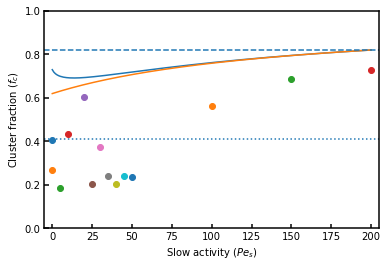

In [9]:
# Let's look at which theory is appropriate

# Constant indices to use
peft = 200.
pfi = list(pefRange).index(peft)
xfi = xfRange.index(0.5)
ei = epsRange.index(1.)

fig = plt.figure()
plt.plot(pesRange, cfs[ei][xfi][pfi])
plt.plot(pesRange, netcfs[ei][xfi][pfi])

# What if we take an average of each monodisperse cluster fraction
monoSlow = cfs[ei][xfi][0][0]
pfi = list(pefRange).index(peft)
psi = list(pesRange).index(peft)
monoFast = cfs[ei][xfi][pfi][psi]
plt.axhline((monoSlow + monoFast) / 2., ls=":")
plt.axhline(monoFast, ls="--")
# plt.axhline(netcfs[ei][][][])

for i in range(0, len(comp)):
    avg = 0
    count = 0
#     for j in range(-10, -1):
#         count += 1
#         avg += (all_comp[i]['NinLC'].iloc[j]/100000.)
#     print(count)
#     avg /= count
#     ind = list(all_comp[i]['tauB']).index(9.0)
    ind = -1
    if params['eps'][i] == 0.1 and params['xA'][i] == 0.5:
        if params['peA'][i] == 200 and params['peA'][i] >= params['peB'][i]:
#             plt.scatter(params['peB'][i], max(all_comp[i]['NinLC'][-10:-1])/100000.)
            plt.scatter(params['peB'][i], all_comp[i]['NinLC'].iloc[ind]/100000.)
        elif params['peB'][i] == 200 and params['peA'][i] <= params['peB'][i]:
#             plt.scatter(params['peA'][i], max(all_comp[i]['NinLC'][-10:-1])/100000.)
            plt.scatter(params['peA'][i], all_comp[i]['NinLC'].iloc[ind]/100000.)
    
plt.xlabel(r'Slow activity $(Pe_{s})$')
plt.ylabel(r'Cluster fraction $(f_{c})$')
plt.xlim(-5, 205)
plt.ylim(0, 1)
plt.show()


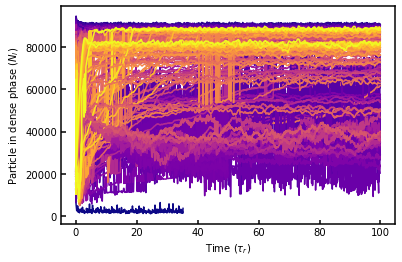

In [10]:
# Let's look at simulation data
for i in range(0, len(all_comp)):
    plt.plot(all_comp[i]['tauB'], all_comp[i]['NinLC'],
             c=plt.cm.plasma((params['peN'][i] - min(params['peN']))/(max(params['peN']- min(params['peN'])))),
             label=params['peN'][i])

# plt.xlim(0, 50)
# plt.legend(bbox_to_anchor=(1.0, 1.03), title=r'$Pe_{N}$')
plt.xlabel(r'Time $(\tau_{r})$')
plt.ylabel(r'Particle in dense phase $(N_{l})$')
plt.show()


In [11]:
# # Let's plot things and see what's happening

# # Set range of epsilon
# # epsRange = [1., 0.1, 0.01, 0.001, 0.0001]
# epsRange = [0.0001, 1.0]
# epsRange.sort()
# epsCols = []
# for i in range(0, len(epsRange)):
#     epsCols.append(plt.cm.jet(float(i)/len(epsRange)))
    
# # Set the range of particle fractions
# # xfRange = np.arange(0.0, 1.1, 0.1)
# xfRange = [0.1, 0.5, 0.9]
# xfRange.sort()
# xfCols = []
# for i in range(0, len(xfRange)):
#     epsCols.append(plt.cm.viridis(float(i)/len(xfRange)))
    
# # Set range of Pe S/F
# pefRange = np.arange(0.0, 251.0, 1.0)
# pefRange = [250., 500.]
# pesRange = np.arange(0.0, 251.0, 1.0)
# N = 100000.
# norm = 10.**0.

# phiCP = np.pi / (2. * np.sqrt(3))
# phi = 0.6
# lat = []
# latF = []
# latS = []
# pLJ = []
# cfs = []
# Rls = []
# peCrit = []
# phiGs = []
# phiCPs = []
# peNets = []

# for i in range(0, len(epsRange)):
#     # Add index for this epsilon
#     lat.append([])
#     latF.append([])
#     latS.append([])
#     pLJ.append([])
#     cfs.append([])
#     Rls.append([])
#     peCrit.append([])
#     phiGs.append([])
#     phiCPs.append([])
#     peNets.append([])
#     for j in range(0, len(xfRange)):
#         # Add index for this xf
#         lat[i].append([])
#         latF[i].append([])
#         latS[i].append([])
#         pLJ[i].append([])
#         cfs[i].append([])
#         Rls[i].append([])
#         peCrit[i].append([])
#         phiGs[i].append([])
#         phiCPs[i].append([])
#         peNets[i].append([])
#         for k in range(0, len(pefRange)):
#             # Add index for this pef
#             lat[i][j].append([])
#             latF[i][j].append([])
#             latS[i][j].append([])
#             pLJ[i][j].append([])
#             cfs[i][j].append([])
#             Rls[i][j].append([])
#             peCrit[i][j].append([])
#             phiGs[i][j].append([])
#             phiCPs[i][j].append([])
#             peNets[i][j].append([])
#             for l in range(0, len(pesRange)):
#                 # Get values, swap if necessary
#                 cpes = pesRange[l]
#                 cpef = pefRange[k]
#                 cxf = xfRange[j]
#                 if pesRange[l] > pefRange[k]:
#                     cpes = pefRange[k]
#                     cpef = pesRange[l]
#                     cxf = 1. - xfRange[j]
#                 # Compute net activity
#                 peNet = compPeNet(cxf, cpes, cpef)
#                 peNets[i][j][k].append(peNet)
                
#                 # Compute lattice spacing (from pe net and individually)
#                 cLat = conForRClust(peNet, epsRange[i])
#                 sLat = conForRClust(cpes, epsRange[i])
#                 fLat = conForRClust(cpef, epsRange[i])
#                 lat[i][j][k].append(cLat)
#                 latF[i][j][k].append(fLat)
#                 latS[i][j][k].append(sLat)
                
#                 # Compute pressure
#                 cPLJ = ljPress(cLat, epsRange[i])
#                 pLJ[i][j][k].append(cPLJ)
                
#                 # Compute phiG
# #                 compPhiG(phi, peS, peF, xF, aF, aS, sigma=1., kappa=4.05)
#                 cphiG = compPhiG(phi, cpes, cpef, cxf, fLat, sLat)
#                 phiGs[i][j][k].append(cphiG)
    
#                 # Compute cluster fraction
#                 if phiGs == phi:
#                     ccf = 0.
#                 else:
#                     ccf = clustFrac(phi, cphiG, fLat, sLat, cxf)
#                 if ccf < 0. or ccf > 1.:
#                     ccf = 0.
#                 cfs[i][j][k].append(ccf)
                
#                 # Compute cluster size
#                 Nl = ccf * N
#                 Al = Nl * (np.pi * (cLat**2) * 0.25)
#                 cRl = np.sqrt(Al / (np.pi))
#                 Rls[i][j][k].append(cRl)
#     # This is just to see how fast things are moving along
#     print(i)

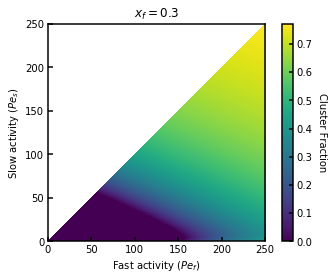

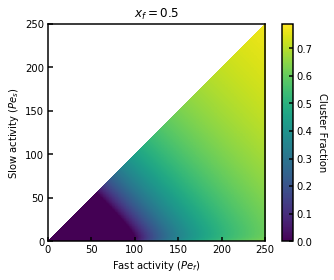

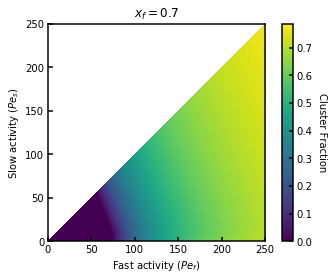

In [12]:
# Let's loop through xF to show how this effects mixtures
for z in range(0, len(xfRange)):
    # Let's look at the cluster fraction (for constant xf and epsilon)    
    pltCF = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
    pltPhiG = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
    for k in range(0, len(pefRange)):
        for l in range(0, len(pesRange)):
            pltCF[k][l] = cfs[0][z][k][l]
            pltPhiG[k][l] = phiGs[0][z][k][l]
    # Plot the heatmap you've made
#     print(np.amax(pltCF))
    fig, ax = plt.subplots()
#     im = ax.imshow(pltPhiG.T, origin='lower', extent=(0., 500., 0., 500.))
    im = ax.imshow(pltCF.T, origin='lower', extent=(0., 250., 0., 250.))
    cbar = plt.colorbar(im)
    cbar.set_label(r'Cluster Fraction', rotation=270, labelpad=15)
    ax.set_title(r'$x_{f}=$' + str(xfRange[z]))
    ax.set_xlabel(r'Fast activity $(Pe_{f})$')
    ax.set_ylabel(r'Slow activity $(Pe_{s})$')
    plt.show()
        

eps=0.0001, Pe=18.0
eps=0.01, Pe=17.0
eps=1.0, Pe=12.0


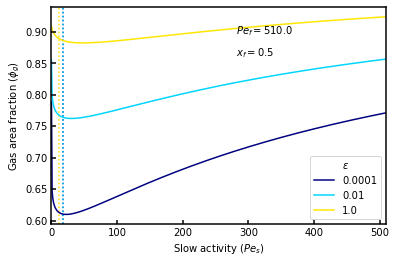

xf=0.3, Pe=11.0
xf=0.5, Pe=18.0
xf=0.7, Pe=24.0


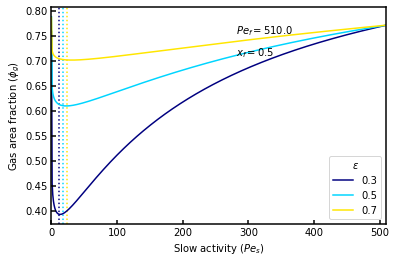

In [13]:
# Prove that the heatmap is actually continuous
kappa = 4.05
sigma = 1.0
ei = 0
xi = xfRange.index(0.5)
pfi = -1

# Index for maximum phiG
mpgi = phiGs[0][xi][pfi].index(max(phiGs[0][xi][pfi]))
maxPe = pesRange[mpgi]

for i in range(0, len(epsRange)):
    plt.plot(pesRange, cfs[i][xi][pfi], c=plt.cm.jet(float(i)/len(epsRange)), label=epsRange[i], zorder=1)
    # Index for maximum phiG
    mpgi = phiGs[i][xi][pfi].index(max(phiGs[i][xi][pfi]))
    maxPe = pesRange[mpgi]
    print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    plt.axvline(maxPe, c=plt.cm.jet(float(i)/len(epsRange)), zorder=0, ls=':')
    
ax = plt.gca()
plt.text(x=0.55, y=0.875, s=r'$Pe_{f}=$' + str(pefRange[pfi]), transform=ax.transAxes)
plt.text(x=0.55, y=0.775, s=r'$x_{f}=$' + str(xfRange[xi]), transform=ax.transAxes)
plt.legend(title=r'$\epsilon$')
plt.xlim(min(pesRange), max(pesRange))
plt.xlabel(r'Slow activity $(Pe_{s})$')
plt.ylabel(r'Gas area fraction $(\phi_{g})$')
plt.show()
    
for i in range(0, len(xfRange)):
    plt.plot(pesRange, cfs[0][i][pfi], c=plt.cm.jet(float(i)/len(xfRange)), label=xfRange[i], zorder=1)
    # Index for maximum phiG
    mpgi = phiGs[0][i][pfi].index(max(phiGs[0][i][pfi]))
    maxPe = pesRange[mpgi]
    print(r'xf={}, Pe={}').format(xfRange[i], maxPe)
    plt.axvline(maxPe, c=plt.cm.jet(float(i)/len(xfRange)), zorder=0, ls=':')
    
ax = plt.gca()
plt.text(x=0.55, y=0.875, s=r'$Pe_{f}=$' + str(pefRange[pfi]), transform=ax.transAxes)
plt.text(x=0.55, y=0.775, s=r'$x_{f}=$' + str(xfRange[xi]), transform=ax.transAxes)
plt.legend(title=r'$\epsilon$')
plt.xlim(min(pesRange), max(pesRange))
# plt.ylim(0.1, 0.3)
plt.xlabel(r'Slow activity $(Pe_{s})$')
plt.ylabel(r'Gas area fraction $(\phi_{g})$')
plt.show()


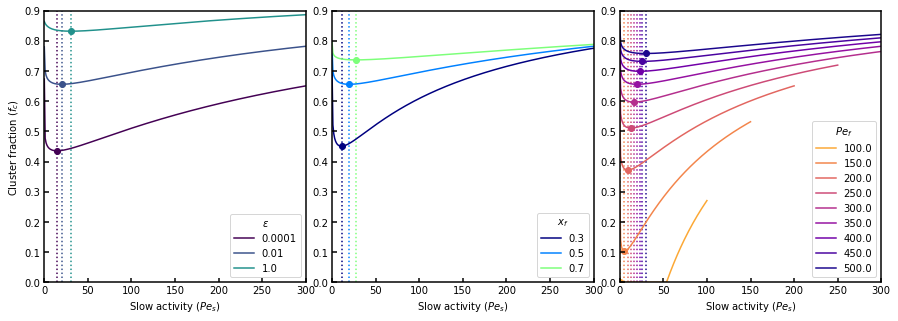

In [14]:
# 1 x 3 plot show effect of eps, xf, pef on location of minimum
fig = plt.figure(figsize=(15, 5))
gs = plt.GridSpec(1, 3, wspace=0.1, figure=fig, width_ratios=[1, 1, 1])
ax = []
# Add axis for each plot
ax.append(plt.subplot(gs[0]))
ax.append(plt.subplot(gs[1]))
ax.append(plt.subplot(gs[2]))

# Constant indices to use
pfi = list(pefRange).index(350.)
xfi = xfRange.index(0.5)
ei = 1

# Loop through and plot varied eps
colshift = 1
for i in range(0, len(epsRange)):
    ax[0].plot(pesRange, cfs[i][xi][pfi], c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)), label=epsRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[i][xfi][pfi] if x is not None)
    mpgi = cfs[i][xi][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[0].scatter(minpe, mincf, c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[0].axvline(minpe, c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)), zorder=0, ls=':')
    ax[0].set_xlim(min(pesRange), 100.)
    ax[0].set_xlabel(r'Slow activity $(Pe_{s})$')
    ax[0].set_ylabel(r'Cluster fraction $(f_{c})$')
ax[0].legend(title=r'$\epsilon$')
    
# Loop through and plot varied eps
colshift = 1
for i in range(0, len(xfRange)):
    ax[1].plot(pesRange, cfs[ei][i][pfi], c=plt.cm.jet(float(i)/(len(xfRange)+colshift)), label=xfRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[ei][i][pfi] if x is not None)
    mpgi = cfs[ei][i][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[1].scatter(minpe, mincf, c=plt.cm.jet(float(i)/(len(xfRange)+colshift)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[1].axvline(minpe, c=plt.cm.jet(float(i)/(len(xfRange)+colshift)), zorder=0, ls=':')
    ax[1].set_xlim(min(pesRange), 100.)
    ax[1].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[1].legend(title=r'$x_{f}$')
    
# Loop through and plot varied eps
for i in range(100, len(pefRange), 50):
    ax[2].plot(pesRange, cfs[ei][xi][i], c=plt.cm.plasma_r(float(i)/len(pefRange)), label=pefRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[ei][xi][i] if x is not None)
    mpgi = cfs[ei][xi][i].index(mincf)
    minpe = pesRange[mpgi]
    ax[2].scatter(minpe, mincf, c=plt.cm.plasma_r(float(i)/len(pefRange)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[2].axvline(minpe, c=plt.cm.plasma_r(float(i)/len(pefRange)), zorder=0, ls=':')
    ax[2].set_xlim(min(pesRange), 100.)
    ax[2].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[2].legend(title=r'$Pe_{f}$')
    
for i in range(0, len(ax)):
    ax[i].set_xlim(0, 300)
#     ax[i].set_ylim(0, 0.8)
    ax[i].set_ylim(0.0, 0.9)
    
# plt.text(x=0.55, y=0.875, s=r'$Pe_{f}=$' + str(pefRange[pfi]), transform=ax.transAxes)
# plt.text(x=0.55, y=0.775, s=r'$x_{f}=$' + str(xfRange[xi]), transform=ax.transAxes)
plt.show()

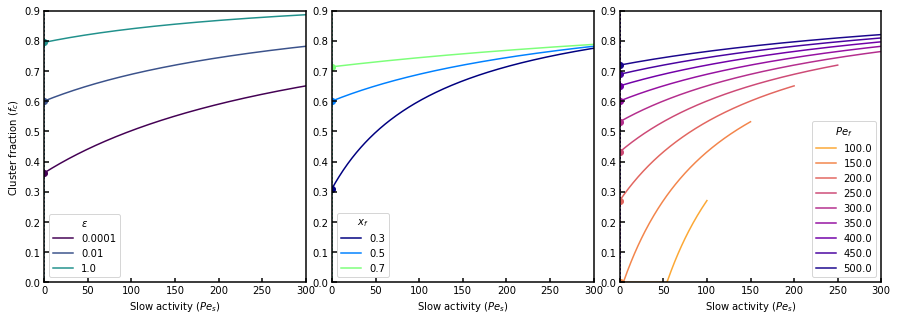

In [15]:
# 1 x 3 plot show effect of eps, xf, pef on location of minimum
fig = plt.figure(figsize=(15, 5))
gs = plt.GridSpec(1, 3, wspace=0.1, figure=fig, width_ratios=[1, 1, 1])
ax = []
# Add axis for each plot
ax.append(plt.subplot(gs[0]))
ax.append(plt.subplot(gs[1]))
ax.append(plt.subplot(gs[2]))

# Constant indices to use
pfi = list(pefRange).index(350.)
xfi = xfRange.index(0.5)
ei = 1

# Loop through and plot varied eps
colshift = 1
for i in range(0, len(epsRange)):
    ax[0].plot(pesRange, netcfs[i][xi][pfi], c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)), label=epsRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in netcfs[i][xfi][pfi] if x is not None)
    mpgi = netcfs[i][xi][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[0].scatter(minpe, mincf, c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[0].axvline(minpe, c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)), zorder=0, ls=':')
    ax[0].set_xlim(min(pesRange), 100.)
    ax[0].set_xlabel(r'Slow activity $(Pe_{s})$')
    ax[0].set_ylabel(r'Cluster fraction $(f_{c})$')
ax[0].legend(title=r'$\epsilon$')
    
# Loop through and plot varied eps
colshift = 1
for i in range(0, len(xfRange)):
    ax[1].plot(pesRange, netcfs[ei][i][pfi], c=plt.cm.jet(float(i)/(len(xfRange)+colshift)), label=xfRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in netcfs[ei][i][pfi] if x is not None)
    mpgi = netcfs[ei][i][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[1].scatter(minpe, mincf, c=plt.cm.jet(float(i)/(len(xfRange)+colshift)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[1].axvline(minpe, c=plt.cm.jet(float(i)/(len(xfRange)+colshift)), zorder=0, ls=':')
    ax[1].set_xlim(min(pesRange), 100.)
    ax[1].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[1].legend(title=r'$x_{f}$')
    
# Loop through and plot varied eps
for i in range(100, len(pefRange), 50):
    ax[2].plot(pesRange, netcfs[ei][xi][i], c=plt.cm.plasma_r(float(i)/len(pefRange)), label=pefRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in netcfs[ei][xi][i] if x is not None)
    mpgi = netcfs[ei][xi][i].index(mincf)
    minpe = pesRange[mpgi]
    ax[2].scatter(minpe, mincf, c=plt.cm.plasma_r(float(i)/len(pefRange)))
#     print(r'eps={}, Pe={}').format(epsRange[i], maxPe)
    ax[2].axvline(minpe, c=plt.cm.plasma_r(float(i)/len(pefRange)), zorder=0, ls=':')
    ax[2].set_xlim(min(pesRange), 100.)
    ax[2].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[2].legend(title=r'$Pe_{f}$')
    
for i in range(0, len(ax)):
    ax[i].set_xlim(0, 300)
#     ax[i].set_ylim(0, 0.8)
    ax[i].set_ylim(0.0, 0.9)
    
# plt.text(x=0.55, y=0.875, s=r'$Pe_{f}=$' + str(pefRange[pfi]), transform=ax.transAxes)
# plt.text(x=0.55, y=0.775, s=r'$x_{f}=$' + str(xfRange[xi]), transform=ax.transAxes)
plt.show()

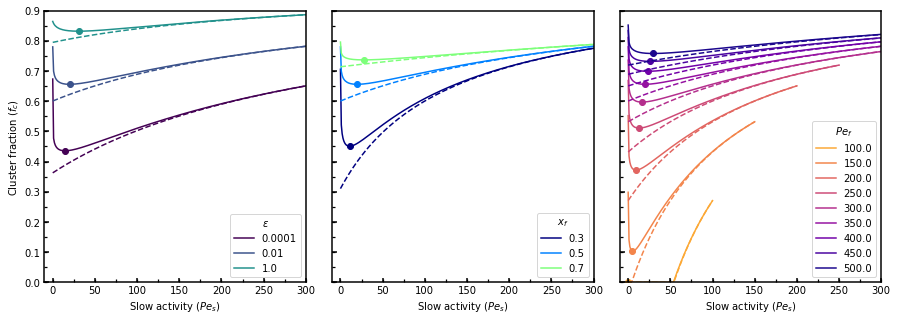

In [23]:
# 1 x 3 plot show effect of eps, xf, pef on location of minimum
fig = plt.figure(figsize=(15, 5))
gs = plt.GridSpec(1, 3, wspace=0.1, figure=fig, width_ratios=[1, 1, 1])
ax = []
# Add axis for each plot
ax.append(plt.subplot(gs[0]))
ax.append(plt.subplot(gs[1]))
ax.append(plt.subplot(gs[2]))

# Constant indices to use
pfi = list(pefRange).index(350.)
xfi = xfRange.index(0.5)
ei = 1

# Loop through and plot varied eps
colshift = 1
for i in range(0, len(epsRange)):
    ax[0].plot(pesRange, netcfs[i][xi][pfi], c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)),
               zorder=1, ls='--')
    ax[0].plot(pesRange, cfs[i][xi][pfi], c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)), label=epsRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[i][xfi][pfi] if x is not None)
    mpgi = cfs[i][xi][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[0].scatter(minpe, mincf, c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)))
    ax[0].set_xlim(min(pesRange), 100.)
    ax[0].set_xlabel(r'Slow activity $(Pe_{s})$')
    ax[0].set_ylabel(r'Cluster fraction $(f_{c})$')
ax[0].legend(title=r'$\epsilon$', loc='lower right')
    
# Loop through and plot varied eps
colshift = 1
for i in range(0, len(xfRange)):
    ax[1].plot(pesRange, netcfs[ei][i][pfi], c=plt.cm.jet(float(i)/(len(xfRange)+colshift)),
               zorder=1, ls='--')
    ax[1].plot(pesRange, cfs[ei][i][pfi], c=plt.cm.jet(float(i)/(len(xfRange)+colshift)), label=xfRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[ei][i][pfi] if x is not None)
    mpgi = cfs[ei][i][pfi].index(mincf)
    minpe = pesRange[mpgi]
    ax[1].scatter(minpe, mincf, c=plt.cm.jet(float(i)/(len(xfRange)+colshift)))
    ax[1].set_xlim(min(pesRange), 100.)
    ax[1].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[1].legend(title=r'$x_{f}$', loc='lower right')
    
# Loop through and plot varied eps
for i in range(100, len(pefRange), 50):
    ax[2].plot(pesRange, netcfs[ei][xi][i], c=plt.cm.plasma_r(float(i)/len(pefRange)),
               zorder=1, ls='--')
    ax[2].plot(pesRange, cfs[ei][xi][i], c=plt.cm.plasma_r(float(i)/len(pefRange)), label=pefRange[i], zorder=1)
    # Index for maximum cf
    mincf = min(x for x in cfs[ei][xi][i] if x is not None)
    mpgi = cfs[ei][xi][i].index(mincf)
    minpe = pesRange[mpgi]
    ax[2].scatter(minpe, mincf, c=plt.cm.plasma_r(float(i)/len(pefRange)))
    ax[2].set_xlim(min(pesRange), 100.)
    ax[2].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[2].legend(title=r'$Pe_{f}$', loc='lower right')
    
for i in range(0, len(ax)):
    ax[i].set_xlim(-10, 300)
#     ax[i].set_ylim(0, 0.8)
    ax[i].set_ylim(0.0, 0.9)
    if i > 0:
        ax[i].set_yticklabels([])
    # Set ticks
    loc = ticker.MultipleLocator(base=50)
    ax[i].xaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=25)
    ax[i].xaxis.set_minor_locator(loc)
    loc = ticker.MultipleLocator(base=0.1)
    ax[i].yaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=0.05)
    ax[i].yaxis.set_minor_locator(loc)
    
# plt.text(x=0.55, y=0.875, s=r'$Pe_{f}=$' + str(pefRange[pfi]), transform=ax.transAxes)
# plt.text(x =0.55, y=0.775, s=r'$x_{f}=$' + str(xfRange[xi]), transform=ax.transAxes)
plt.subplots_adjust(wspace=0.1)
plt.savefig('compare_theories.pdf', bbox_inches='tight', pad_inches=0.02, dpi=1000)
plt.show()


In [ ]:
# You should be able to make a list of the minimum in cf for each param
mincfs = []
minpes = []
for i in range(0, len(epsRange)):
    mincfs.append([])
    minpes.append([])
    for j in range(0, len(xfRange)):
        mincfs[i].append([])
        minpes[i].append([])
        for k in range(0, len(pefRange)):
            mincf = min(x for x in cfs[i][j][k] if x is not None)
            mpsi = cfs[i][j][k].index(mincf)
            minpe = pesRange[mpsi]
            mincfs[i][j].append(mincf)
            minpes[i][j].append(minpe)

# Let's look at how the minimum value of cf changes
for i in range(0, len(epsRange)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for j in range(0, len(xfRange)):
        ax[0].plot(pefRange, mincfs[i][j])
        ax[1].plot(pefRange, minpes[i][j])
#         plt.plot(minpes[i][j], mincfs[i][j])
#         plt.xlabel(r'Slow activity at minimum cluster fraction')
#         plt.ylabel(r'Minimum cluster fraction')
#         plt.title(xfRange[j])
#         plt.xlim(0, 50)
#         plt.ylim(0, 1)
    ax[0].set_xlim(0, 500)
    ax[0].set_ylim(0, 1)
    plt.show()
            

In [ ]:
# Convenient plotting function
# A nice function for plotting colorbars
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.2)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

if len(xfRange) > 1:
    # Let's get the slow activity where cfs is at a minimum for each pef
    mincfs = []
    mcfmag = []
    for i in range(0, len(epsRange)):
        mincfs.append([])
        mcfmag.append([])
        for j in range(0, len(xfRange)):
            mincfs[i].append([])
            mcfmag[i].append([])
            for k in range(0, len(pefRange)):
                # Get the minimum value of cf
                mymin = min(x for x in cfs[i][j][k] if x is not None)
                # Get the maximum value of cf
                mxcf = max(x for x in cfs[i][j][k] if x is not None)
                mcfi = cfs[i][j][k].index(mymin)
                mincfpe = pesRange[mcfi]
                # What is the maximum value of cf at that activity
                mincfs[i][j].append(mincfpe)
    #             mcfmag[i][j].append(np.abs(1.-mymin))
                mcfmag[i][j].append(mxcf-mymin)

    # Let's loop through xF to show how this effects mixtures
    for i in range(0, len(epsRange)):
        fig = plt.figure(figsize=(15, 5))
        gs = plt.GridSpec(nrows=1, ncols=len(xfRange), wspace=0.1, figure=fig, width_ratios=[1, 1, 1.125])
        ax = []
        for j in range(0, len(xfRange)):
            ax.append(plt.subplot(gs[0, j]))
        for j in range(0, len(xfRange)):
            # Let's look at the cluster fraction (for constant xf and epsilon)    
            pltCF = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
            pltPhiG = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
            for k in range(0, len(pefRange)):
                for l in range(0, len(pesRange)):
                    pltCF[k][l] = cfs[i][j][k][l]
                    pltPhiG[k][l] = phiGs[i][j][k][l]
            # Plot the heatmap you've made
            im = ax[j].imshow(pltCF.T, origin='lower', 
                              extent=(pefRange[0], pefRange[-1], pesRange[0], pesRange[-1]), 
                              vmin=0, vmax=0.85)
            # Plot the minimum in cf
            ax[j].scatter(pefRange, mincfs[i][j], c=plt.cm.jet(mcfmag[i][j]), s=10.0, zorder=2)
            ax[j].text(0.1, 0.8, r'$\epsilon=$' + str(epsRange[i]), transform=ax[j].transAxes)
            ax[j].text(0.1, 0.9, r'$x_{f}=$' + str(xfRange[j]), transform=ax[j].transAxes)
            ax[j].set_xlabel(r'Fast activity $(Pe_{f})$')
            ax[j].set_xlim(0, pefRange[-1])
            ax[j].set_ylim(0, pesRange[-1])
            if j > 0:
                ax[j].set_yticks([])
        ax[0].set_ylabel(r'Slow activity $(Pe_{s})$')    
        cbar = colorbar(im)
        cbar.set_label(r'Cluster Fraction', rotation=270, labelpad=15)
        plt.show()

In [ ]:
# Let's look at how the minimum value of cf changes
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Varied epsilon
for i in range(0, len(epsRange)):
    ax[0].plot(pesRange, Rls[i][xi][pfi], c=plt.cm.viridis(float(i)/(len(epsRange)+colshift)))
    
# Varied particle fraction
for j in range(0, len(xfRange)):
    ax[1].plot(pesRange, Rls[ei][j][pfi], c=plt.cm.jet(float(j)/(len(xfRange)+colshift)))

# Varied pe fast
for k in range(100, len(pefRange), 50):
    ax[2].plot(pesRange, Rls[ei][xi][k], c=plt.cm.plasma_r(float(k)/len(pefRange)))
    
for i in range(0, len(ax)):
    ax[i].set_xlim(-5, 100)
    ax[i].set_ylim(0, 90)
    ax[i].set_xlabel(r'Slow activity $(Pe_{s})$')
ax[0].set_ylabel(r'$r_{c}$')
plt.show()
            

In [ ]:
# Let's look at the net activity, does the theory predict that it will set the binodal
# for i in range(0, len(epsRange)):
#     for j in range(0, len(xfRange)):
#         for k in range(0, len(pefRange)):
#             for l in range(0, len(pesRange)):
# plt.scatter(peNets, phiL)
# plt.show()
# plt.scatter(peNets, phiLf)
# plt.show()
# plt.scatter(peNets, phiLs)
# plt.show()

In [ ]:
# # Let's take a look at phiG
# for i in range(0, len(epsRange)):
#     for j in range(0, len(xfRange)):
#         plt.scatter(peNets[i][j], phiGs[i][j])
#         plt.show()

In [ ]:
# What does the relationship look like for peNet?
for i in range(0, len(epsRange)):
    plt.scatter(peNets[i], phiL[i])
    plt.scatter(peNets[i], netPhiGs[i])
    plt.xlim(-10, 510)
    plt.ylim(0, 6)
    plt.show()

In [ ]:
# Let's make plots of quantities with respect to PeNet

# Cluster fraction
for i in range(0, len(epsRange)):
    for j in range(0, len(xfRange)):
#         for k in range(0, len(pefRange)):
        plt.plot(peNets[i][j], netcfs[i][j])
    plt.show()

In [ ]:
# Overlay theory on simulation (which looks better)
plotEps = [0.1, 1.0]
xfi = xfRange.index(0.5)
for i in range(0, len(epsRange)):
    if epsRange[i] in plotEps:
        plt.plot(peNets[i][xfi], phiL[i][xfi], c='k', ls='--')
        plt.plot(peNets[i][xfi], phiGs[i][xfi], ls='--')

# Let's start taking a peak at simulation data
for i in range(0, len(all_comp)):
    if all_comp[i]['phiL'].iloc[-1] > 0.7:
        plt.scatter(params['peN'][i], all_comp[i]['phiL'].iloc[-1])
    if all_comp[i]['phiG'].iloc[-1] < 0.5:
        plt.scatter(params['peN'][i], all_comp[i]['phiG'].iloc[-1])
plt.show()

In [ ]:
# Let's just grab single lines
penetRange = np.arange(0., 500., 1.)
liq = []
gas = []
for i in range(0, len(epsRange)):
    liq.append([])
    gas.append([])
    for j in range(0, len(penetRange)):
        cLat = conForRClust(penetRange[j], epsRange[i])
        cnetPhiG = netPhiG(penetRange[j], cLat)
        liq[i].append(latToPhi(cLat))
        gas[i].append(cnetPhiG)

In [ ]:
# Get colors for plotting
epsCol = [1., 0.1, 0.01, 0.001, 0.0001]
lec = float(len(epsCol)-1)

In [ ]:
# Plot theory
for i in range(0, len(epsRange)):
    if epsRange[i] in plotEps:
        ind = epsCol.index(epsRange[i])
        plt.plot(penetRange, liq[i], c=plt.cm.jet(ind/lec))
        plt.plot(penetRange, gas[i], c=plt.cm.jet(ind/lec))

# Overlay with simulation data
for i in range(0, len(all_comp)):
    ind = epsCol.index(params['eps'][i])
    if all_comp[i]['phiL'].iloc[-1] > 0.7:
        plt.scatter(params['peN'][i], all_comp[i]['phiL'].iloc[-1], c=plt.cm.jet(ind/lec))
    if all_comp[i]['phiG'].iloc[-1] < 0.5:
        plt.scatter(params['peN'][i], all_comp[i]['phiG'].iloc[-1], c=plt.cm.jet(ind/lec))
plt.xlim(90, 500)
plt.ylim(0, 2.2)
plt.xlabel(r'Net activity $(Pe_{net})$')
plt.ylabel(r'Local area fraction $(\phi_{loc})$')
plt.show()

In [ ]:
# Plot as side by side
# fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig = plt.figure(figsize=(11.5, 5))
xfi = xfRange.index(0.5)

pgs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1., 1.4], wspace=0.12)
ax = []
ax.append(fig.add_subplot(pgs[0]))
ax.append(fig.add_subplot(pgs[1]))

# Plot theory
for i in range(0, len(epsRange)):
    ind = epsCol.index(epsRange[i])
    if epsRange[i] == 1.:
#         ax[0].plot(penetRange, liq[i], c=plt.cm.jet(ind/lec))
#         ax[0].plot(penetRange, gas[i], c=plt.cm.jet(ind/lec))
        ax[0].plot(penetRange, liq[i], c='k', ls='--', zorder=0)
        ax[0].plot(penetRange, gas[i], c='k', ls=':', zorder=0)
    if epsRange[i] == 0.1:
        ax[1].plot(penetRange, liq[i], c='k', ls='--', zorder=0)
        ax[1].plot(penetRange, gas[i], c='k', ls=':', zorder=0)

# Overlay with simulation data
for i in range(0, len(all_comp)):
#     ind = epsCol.index(params['eps'][i])
    # Get color (activity ratio)
    if params['peB'][i] > params['peA'][i]:
        nowper = (params['peA'][i] / float(params['peB'][i]))
    elif params['peA'][i] == params['peB'][i] == 0.:
        nowper = 0.
    else: 
        nowper = (params['peB'][i] / float(params['peA'][i]))
    # Get axis to plot on (via epsilon)
    if params['eps'][i] == 1.:
        axi = 0
    else:
        axi = 1
    # Plot data
    if all_comp[i]['phiL'].iloc[-1] > 0.7:
        ax[axi].scatter(params['peN'][i], all_comp[i]['phiL'].iloc[-1], 
                        c=plt.cm.viridis_r(nowper), zorder=((-nowper)+1.))
    if all_comp[i]['phiG'].iloc[-1] < 0.5:
        ax[axi].scatter(params['peN'][i], all_comp[i]['phiG'].iloc[-1], 
                        c=plt.cm.viridis_r(nowper), zorder=((-nowper)+1.))
for i in range(0, len(ax)):
    ax[i].set_xlim(90, 500)
    ax[i].set_ylim(0, 2.25)
    ax[i].set_xlabel(r'Net activity $(Pe_{net})$')
ax[0].set_ylabel(r'Local area fraction $(\phi_{loc})$')
ax[0].text(0.05, 0.925, r'$\epsilon=1$',  transform=ax[0].transAxes)
ax[1].text(0.05, 0.925, r'$\epsilon=0.1$',  transform=ax[1].transAxes)

# Set ticks
loc = ticker.MultipleLocator(base=100)
ax[0].xaxis.set_major_locator(loc)
ax[1].xaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=50)
ax[0].xaxis.set_minor_locator(loc)
ax[1].xaxis.set_minor_locator(loc)
loc = ticker.MultipleLocator(base=0.5)
ax[0].yaxis.set_major_locator(loc)
ax[1].yaxis.set_major_locator(loc)
loc = ticker.MultipleLocator(base=0.25)
ax[0].yaxis.set_minor_locator(loc)
ax[1].yaxis.set_minor_locator(loc)

# Add colorbar
cmap = mpl.cm.viridis_r
mynorm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
sm = mpl.cm.ScalarMappable(norm=mynorm, cmap=cmap)
sm.set_array([])
cb1 = fig.colorbar(sm, ax=ax[1], fraction=0.24, orientation='vertical')
cb1.set_label(r'$Pe_{R}$', fontsize=fsize)

plt.subplots_adjust(wspace=0.1)
plt.savefig('binary_soft_phase.pdf', bbox_inches='tight', pad_inches=0.02, dpi=1000)
plt.show()

In [ ]:
# Let's get a side by side plot for net activity approach
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
xfi = xfRange.index(0.5)
   
# for i in range(0, len(epsRange)):
#     if epsRange[i] == 1.:
#         ax[0].scatter(peNets[i][xfi], phiL[i][xfi], c=pers[i][xfi], zorder=pers[i][xfi])
#         ax[0].scatter(peNets[i][xfi], netPhiGs[i][xfi], c=pers[i][xfi], zorder=pers[i][xfi])
#     if epsRange[i] == 0.1:
#         ax[1].scatter(peNets[i][xfi], phiL[i][xfi], c=pers[i][xfi])
#         ax[1].scatter(peNets[i][xfi], netPhiGs[i][xfi], c=pers[i][xfi])
for i in range(0, len(epsRange)):
    if epsRange[i] == 1.:
        ax[0].plot(peNets[i][xfi], phiL[i][xfi], c='k')
        ax[0].plot(peNets[i][xfi], netPhiGs[i][xfi])
    if epsRange[i] == 0.1:
        ax[1].plot(peNets[i][xfi], phiL[i][xfi])
        ax[1].plot(peNets[i][xfi], netPhiGs[i][xfi])
        
# Overlay with simulation data
for i in range(0, len(all_comp)):
    if params['eps'][i] == 1.:
        axi = 0
    else:
        axi = 1
    # A slower than B
    if params['peA'][i] < params['peB'][i]:
        ind_col = plt.cm.jet(params['peA'][i] / float(params['peB'][i]))
    elif params['peA'][i] == params['peB'][i] == 0:
        inc_col = plt.cm.jet(0.)
    # B slower than A (or equal)
    else:
        ind_col = plt.cm.jet(params['peB'][i] / float(params['peA'][i]))
    if all_comp[i]['phiL'].iloc[-1] > 0.7:
        ax[axi].scatter(params['peN'][i], all_comp[i]['phiL'].iloc[-1], c=ind_col)
    if all_comp[i]['phiG'].iloc[-1] < 0.5:
        ax[axi].scatter(params['peN'][i], all_comp[i]['phiG'].iloc[-1], c=ind_col)
        
for i in range(0, len(ax)):
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 2.2)
    ax[i].set_xlabel(r'Net activity $(Pe_{net})$')
ax[0].set_ylabel(r'Local area fraction $(\phi_{loc})$')
plt.show()

In [ ]:
# Let's get those quantities from theory
avg_lats = []
avg_phil = []
xfi = xfRange.index(0.5)
for i in range(0, len(epsRange)):
    avg_lats.append([])
    avg_phil.append([])
    for j in range(0, len(xfRange)):
        avg_lats[i].append([])
        avg_phil[i].append([])
        for k in range(0, len(pefRange)):
            avg_lats[i][j].append([])
            avg_phil[i][j].append([])
            for l in range(0, len(pesRange)):
                if pesRange[l] > pefRange[k]:
                    avg_lats[i][j][k].append(None)
                    avg_phil[i][j][k].append(None)
                    continue
                avg_lat = (latF[i][j][k][l] * xfRange[j]) + (latS[i][j][k][l] * (1. - xfRange[j]))
                avg_lats[i][j][k].append(avg_lat)
                avg_phil[i][j][k].append(latToPhi(avg_lat))

In [ ]:
# Let's overlay second theory with simulation
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
xfi = xfRange.index(0.5)
# for i in range(0, len(epsRange)):
#     for k in range(0, len(pefRange)):
#         for l in range(0, len(pesRange)):
#             if pesRange[l] > pefRange[k]:
#                 continue
#             cind = plt.cm.plasma(pesRange[l]/pefRange[k])
#             plt.scatter(peNets[i][xfi][k][l], avg_phil[i][xfi][k][l], c=cind)
            
for i in range(0, len(epsRange)):
    if epsRange[i] == 1.:
        ax[0].scatter(peNets[i][xfi], avg_phil[i][xfi], c=pers[i][xfi], zorder=pers[i][xfi])
        ax[0].scatter(peNets[i][xfi], phiGs[i][xfi], c=pers[i][xfi], zorder=pers[i][xfi])
    if epsRange[i] == 0.1:
        ax[1].scatter(peNets[i][xfi], avg_phil[i][xfi], c=pers[i][xfi])
        ax[1].scatter(peNets[i][xfi], phiGs[i][xfi], c=pers[i][xfi])
# Overlay with simulation data
for i in range(0, len(all_comp)):
    if params['eps'][i] == 1.:
        axi = 0
    else:
        axi = 1
    # A slower than B
    if params['peA'][i] < params['peB'][i]:
        ind_col = plt.cm.jet(params['peA'][i] / float(params['peB'][i]))
    elif params['peA'][i] == params['peB'][i] == 0:
        inc_col = plt.cm.jet(0.)
    # B slower than A (or equal)
    else:
        ind_col = plt.cm.jet(params['peB'][i] / float(params['peA'][i]))
    if all_comp[i]['phiL'].iloc[-1] > 0.7:
        ax[axi].scatter(params['peN'][i], all_comp[i]['phiL'].iloc[-1], c=ind_col)
    if all_comp[i]['phiG'].iloc[-1] < 0.5:
        ax[axi].scatter(params['peN'][i], all_comp[i]['phiG'].iloc[-1], c=ind_col)
        
for i in range(0, len(ax)):
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 2.2)
    ax[i].set_xlabel(r'Net activity $(Pe_{net})$')
ax[0].set_ylabel(r'Local area fraction $(\phi_{loc})$')
plt.show()

In [ ]:
# Let's see if we can plot constant peR in a better way
rpers = np.arange(0.0, 1.0, 0.01)
rpefs = np.arange(10., 500., 10.0)
rper = []
rpef = []
rpes = []
rpen = []
rphig = []
myeps = 0.1
reps = [1., 0.1]
for h in range(0, len(reps)):
    rper.append([])
    rpef.append([])
    rpes.append([])
    rpen.append([])
    rphig.append([])
    for i in range(0, len(rpers)):
        rper[h].append([])
        rpef[h].append([])
        rpes[h].append([])
        rpen[h].append([])
        rphig[h].append([])
        for j in range(0, len(rpefs)):
            rper[h][i].append(rpers[i])
            rpef[h][i].append(rpefs[j])
            # Get the slow activity
            pes = rpefs[j] * rpers[i]
            rpes[h][i].append(pes)
            # Get the net activity
            pen = (rpefs[j] + pes) / 2.
            rpen[h][i].append(pen)
            # Now let's compute each lattice spacing
            sLat = conForRClust(pes, reps[h])
            fLat = conForRClust(rpefs[j], reps[h])
            phig = compPhiG(0.6, pes, rpefs[j], 0.5, fLat, sLat)
            rphig[h][i].append(phig)

In [ ]:
# Make a figure
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Let's plot these at constant per
for h in range(0, len(reps)):
    if params['eps'][i] == 1.:
        axi = 0
    else:
        axi = 1
    for i in range(0, len(rpers)):
        ax[axi].plot(rpen[h][i], rphig[h][i], c=plt.cm.viridis(rpers[i]))

# Overlay with simulation data
for i in range(0, len(all_comp)):
    if params['eps'][i] == 1.:
        axi = 0
    else:
        axi = 1
    # A slower than B
    if params['peA'][i] < params['peB'][i]:
        ind_col = plt.cm.jet(params['peA'][i] / float(params['peB'][i]))
    elif params['peA'][i] == params['peB'][i] == 0:
        inc_col = plt.cm.jet(0.)
    # B slower than A (or equal)
    else:
        ind_col = plt.cm.jet(params['peB'][i] / float(params['peA'][i]))
    if all_comp[i]['phiL'].iloc[-1] > 0.7:
        ax[axi].scatter(params['peN'][i], all_comp[i]['phiL'].iloc[-1], c=ind_col)
    if all_comp[i]['phiG'].iloc[-1] < 0.5:
        ax[axi].scatter(params['peN'][i], all_comp[i]['phiG'].iloc[-1], c=ind_col)
        
for i in range(0, len(ax)):
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 2.2)
    ax[i].set_xlabel(r'Net activity $(Pe_{net})$')
ax[0].set_ylabel(r'Local area fraction $(\phi_{loc})$')
plt.show()

In [ ]:
# Let's do a simulation and theory comparision of cluster fraction
xfi = xfRange.index(0.5)

fig = plt.figure(figsize=(11.5, 5))
gs = plt.GridSpec(1, 2, wspace=0.05, figure=fig, width_ratios=[1, 1])
plotEps = [1., 0.1]
ax = []
ax.append(fig.add_subplot(gs[0]))
ax.append(fig.add_subplot(gs[1]))
for i in range(0, len(epsRange)):
    if epsRange[i] not in plotEps:
        continue
    mind = plotEps.index(epsRange[i])
    # Let's look at the cluster fraction (for constant xf and epsilon)    
    pltCF = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
    pltPhiG = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
    for k in range(0, len(pefRange)):
        for l in range(0, len(pesRange)):
            pltCF[k][l] = cfs[i][xfi][k][l]
            pltPhiG[k][l] = phiGs[i][xfi][k][l]
    # Plot the heatmap you've made
    im = ax[mind].imshow(pltCF.T, origin='lower', 
                      extent=(pefRange[0], pefRange[-1], pesRange[0], pesRange[-1]), 
                      vmin=0, vmax=0.9)
    # Plot the minimum in cf
    ax[mind].text(0.1, 0.8, r'$\epsilon=$' + str(epsRange[i]), transform=ax[mind].transAxes)
    ax[mind].set_xlabel(r'Fast activity $(Pe_{f})$')
    ax[mind].set_xlim(0, pefRange[-1])
    ax[mind].set_ylim(0, pesRange[-1])
    if mind > 0:
        ax[mind].set_yticks([])
        cbar = colorbar(im)
        cbar.set_label(r'Cluster Fraction', rotation=270, labelpad=15)
    ax[0].set_ylabel(r'Slow activity $(Pe_{s})$')    
    

In [ ]:
# Let's take a look at sim data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(0, len(all_comp)):
    # Only 50:50 data
    if params['xA'][i] != 0.5:
        continue
    mind = plotEps.index(params['eps'][i])
    if params['peB'][i] > params['peA'][i]:
        ax[mind].scatter(params['peB'][i], params['peA'][i], 
                         edgecolors='k', s=50,
                         c=plt.cm.viridis(all_comp[i]['NinLC'].iloc[-1] / 100000.))
    else:
        ax[mind].scatter(params['peA'][i], params['peB'][i],
                         edgecolors='k', s=50,
                         c=plt.cm.viridis(all_comp[i]['NinLC'].iloc[-1] / 90000.))
plt.show()

In [ ]:
# Let's take the average value of NinLC
avgNL = []
for i in range(0, len(all_comp)):
    count = 0
    sumN = 0
    if len(all_comp[i]['NinLC']) <= 100:
        avgNL.append(0)
        continue
    for j in range(len(all_comp[i]['NinLC'])-100, len(all_comp[i]['NinLC'])):
        sumN += all_comp[i]['NinLC'].iloc[j]
        count += 1
    avgNL.append(sumN/count)
print(avgNL)

In [ ]:
# Okay, let's overlay these
xfi = xfRange.index(0.5)

fig = plt.figure(figsize=(11.5, 5))
gs = plt.GridSpec(1, 2, wspace=0.05, figure=fig, width_ratios=[1, 1])
plotEps = [1., 0.1]
ax = []
ax.append(fig.add_subplot(gs[0]))
ax.append(fig.add_subplot(gs[1]))
for i in range(0, len(epsRange)):
    if epsRange[i] not in plotEps:
        continue
    mind = plotEps.index(epsRange[i])
    # Let's look at the cluster fraction (for constant xf and epsilon)    
    pltCF = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
    pltPhiG = np.ndarray(shape=(len(pefRange), len(pesRange)), dtype=float)
    for k in range(0, len(pefRange)):
        for l in range(0, len(pesRange)):
            pltCF[k][l] = cfs[i][xfi][k][l]
            pltPhiG[k][l] = phiGs[i][xfi][k][l]
    # Plot the heatmap you've made
    im = ax[mind].imshow(pltCF.T, origin='lower', 
                      extent=(pefRange[0], pefRange[-1], pesRange[0], pesRange[-1]), 
                      vmin=0, vmax=0.9)
    # Plot the minimum in cf
    ax[mind].text(0.1, 0.9, r'$\epsilon=$' + str(epsRange[i]), transform=ax[mind].transAxes)
    ax[mind].set_xlabel(r'Fast activity $(Pe_{f})$')
    ax[mind].set_xlim(0, pefRange[-1])
    ax[mind].set_ylim(0, pesRange[-1])
    if mind > 0:
        ax[mind].set_yticks([])
        cbar = colorbar(im)
        cbar.set_label(r'Cluster Fraction', rotation=270, labelpad=15)
    ax[0].set_ylabel(r'Slow activity $(Pe_{s})$')    
    
for i in range(0, len(all_comp)):
    # Only 50:50 data
    if params['xA'][i] != 0.5:
        continue
    mind = plotEps.index(params['eps'][i])
#     if params['peB'][i] == 50:
#         print(all_comp[i]['NinLC'].iloc[-1] / 100000.)
#         continue 
#     if params['peB'][i] > params['peA'][i]:
#         ax[mind].scatter(params['peB'][i], params['peA'][i], 
#                          edgecolors='k', s=50,
#                          c=plt.cm.viridis(all_comp[i]['NinLC'].iloc[-1] / 90000.))
#     else:
#         ax[mind].scatter(params['peA'][i], params['peB'][i],
#                          edgecolors='k', s=50,
#                          c=plt.cm.viridis(all_comp[i]['NinLC'].iloc[-1] / 90000.))
    # None of the active/passive ones phase separate
    if params['peB'][i] <= 0. or params['peA'][i] <= 0.:
        if params['eps'][i] == 1.:
            ax[mind].scatter(params['peB'][i], params['peA'][i], 
                             edgecolors='k', linewidths=0.1,
                             s=50,
                             c=plt.cm.viridis(0. / 90000.))
            continue
    # Get rid of outlier
    if params['peB'][i] == 50. and params['peA'][i] == 50. and params['eps'][i] == 1.:
        continue
    if params['peB'][i] > params['peA'][i]:
        ax[mind].scatter(params['peB'][i], params['peA'][i], 
                         edgecolors='k', linewidths=0.1,
                         s=50,
                         c=plt.cm.viridis(avgNL[i] / 90000.))
    else:
        ax[mind].scatter(params['peA'][i], params['peB'][i],
                         edgecolors='k', linewidths=0.1,
                         s=50,
                         c=plt.cm.viridis(avgNL[i] / 90000.))
for i in range(0, len(ax)):
    ax[i].set_xlim(0, 510)
    ax[i].set_ylim(0, 510)
    # Set ticks
    loc = ticker.MultipleLocator(base=100)
    ax[i].xaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=50)
    ax[i].xaxis.set_minor_locator(loc)
    loc = ticker.MultipleLocator(base=100)
    ax[i].yaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=50)
    ax[i].yaxis.set_minor_locator(loc)
    if i > 0:
        ax[i].set_yticks([])
plt.subplots_adjust(wspace=-0.2)
plt.savefig('cf_overlay.pdf', bbox_inches='tight', pad_inches=0.02, dpi=1000)
plt.show()